# SET UP

In [9]:
import numpy as np#manipulation
from scipy.stats import gaussian_kde, shapiro, kstest, norm,qmc, kurtosis, skew#stats
import matplotlib.pyplot as plt#display
import math#sqrt and pi
from scipy.special import factorial
import time#debug
import pandas as pd#display
from fractions import Fraction#display

# FUNCTION

In [2]:
# Fonction pour calculer la VaR
def calculate_var(PNL_list, confidence_level=0.95):
    return np.percentile(PNL_list, (1 - confidence_level) * 100)

# Fonction pour calculer la CVaR par méthode Kernel
def calculate_cvar_kernel(PNL_list, confidence_level=0.95, bandwidth=1.0):
    print(np.shape(PNL_list))
    kde = gaussian_kde(PNL_list)
    print(np.shape(kde))
    x = np.linspace(np.min(PNL_list), np.max(PNL_list), 1000)
    kde_pdf = kde.evaluate(x)
    kde_cdf = np.cumsum(kde_pdf) / np.sum(kde_pdf)
    var = np.percentile(PNL_list, (1 - confidence_level) * 100)
    weight = np.exp(-((x - var) / bandwidth)**2 / 2) # Weighting based on Gaussian kernel
    cvar = np.sum(x * kde_pdf * weight) / np.sum(kde_pdf * weight)
    return cvar

# Fonction pour calculer la CVaR par méthode du choc de CVaR de 1%
def calculate_cvar_shock(PNL, returns, nominales, confidence_level=0.95, shock=5):
    VaR_initial = calculate_var(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    for i in range(n):#nbr de contrat
        nominales_perturbees = np.zeros(n)
        for j,x in enumerate(nominales):
            if j!=i:
                nominales_perturbees[j]=x
            else:
                nominales_perturbees[j] = x*(1+(shock / 100))
        PNL_perturbé = nominales_perturbees * np.exp(returns) - nominales_perturbees
        VaR_perturbée = calculate_var(np.sum(PNL_perturbé, axis=1), confidence_level)
        CVAR_i[i] = (VaR_perturbée - VaR_initial) / (shock / 100)
    return sum(CVAR_i)


#Trouver Béta par dichotomie
def calculate_es(pnl_list, beta):
    var_beta = calculate_var(pnl_list, 1-beta)
    return np.mean([x for x in pnl_list if x <= var_beta])

def find_beta_for_es_equals_var(pnl_list, alpha, tol=1e-5):
    target_var = calculate_var(pnl_list, alpha)

    low_beta = 0
    high_beta = 1.0
    
    while high_beta - low_beta > tol:
        mid_beta = (low_beta + high_beta) / 2
        es_mid_beta = calculate_es(pnl_list, mid_beta)
        
        if es_mid_beta < target_var:
            high_beta = mid_beta
        else:
            low_beta = mid_beta
    
    return (low_beta + high_beta) / 2

In [7]:
def kernel_function(x, num_simulations,kernel_type="gaussian"):
    if kernel_type == "square":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, 1/(2*bandwidth), 0)
    elif kernel_type == "triangle":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, (1 - np.abs(x_scaled))/bandwidth, 0)
    elif kernel_type == "gaussian":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        stdev = bandwidth/math.sqrt(6)
        x_scaled = x / bandwidth
        return norm.pdf(x,scale=bandwidth/math.sqrt(6))
    elif kernel_type == "epanechnikov":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, 3 / (4 * bandwidth) * (1 - x_scaled**2), 0)
    elif kernel_type == "quartic":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, 15 / (16 * bandwidth) * (1 - x_scaled**2)**2, 0)
    else:
        raise ValueError("Unsupported kernel type")

def calculate_VaR(PnL_total, confidence_level=0.95):
    return np.percentile(PnL_total, (1 - confidence_level)* 100)

def calculate_es(pnl_list, beta, lets_go=False):
    var_beta = np.percentile(pnl_list, (1 - beta)* 100)
    pnl_tail = [x for x in pnl_list if x <= var_beta]
    #print("ES",len(pnl_tail))
    return np.mean(pnl_tail)

def calculate_CVARi(PnL_matrix,num_traj,confidence_level=0.95, kernel_type="gaussian"):
    n_scenarios, n_components = PnL_matrix.shape
    PnL_total = np.sum(PnL_matrix, axis=1)
    VaR = calculate_VaR(PnL_total, confidence_level)
    bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
    distances = (PnL_total - VaR)
    #if kernel_type == "triangle":
        #bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        #distances = (PnL_total - VaR) / bandwidth
    weights = kernel_function(distances,num_traj,kernel_type)
    weights /= np.sum(weights)
    #print(len([weight for weight in weights if not weight == 0])) for 10k traj : 3033 gaussian, 890 for triangle and square
    CVARi = np.zeros(n_components)
    for i in range(n_components):
        CVARi[i] = np.sum(weights * PnL_matrix[:, i])
    return CVARi, VaR

def extract_scenarios(PnL_matrix, confidence_level=0.95):
    n_scenarios, n_components = PnL_matrix.shape
    PnL_total = np.sum(PnL_matrix, axis=1)
    VaR = calculate_VaR(PnL_total, confidence_level)
    scenario_indices = np.where(PnL_total == VaR)[0]
    if len(scenario_indices) == 0:
        closest_index = np.argmin(np.abs(PnL_total - VaR))
        scenario_indices = [closest_index]
    PnL_scenarios = PnL_matrix[scenario_indices, :]
    return PnL_scenarios,VaR

def calculate_es_individual_from_beta(pnl_matrix, beta):
    _, num_components = pnl_matrix.shape
    es_list = np.zeros(num_components)
    var_beta = np.percentile(np.sum(pnl_matrix, axis=1), (1 - beta)* 100)  # VAR_beta
    
    pnl_filtered_indices = np.sum(pnl_matrix, axis=1) <= var_beta
    for i in range(num_components):
        pnl_component = pnl_matrix[pnl_filtered_indices, i]
        pnl_component_sorted = np.sort(pnl_component)
        
        es_component = np.mean(pnl_component_sorted)
        es_list[i] = es_component
        
    return es_list

def find_beta_for_es_equals_var(pnl_list, alpha, tol=1e-5):
    target_var = calculate_VaR(pnl_list, alpha)
    alpha = 1 - alpha
    #print(target_var)
    low_beta = 0
    high_beta = 4*alpha#pour commencer de manière plus efficace la dichotomie
    while high_beta - low_beta > tol:
        mid_beta = (low_beta + high_beta) / 2
        es_mid_beta = calculate_es(pnl_list, 1-mid_beta)
        if es_mid_beta > target_var:
            high_beta = mid_beta
        else:
            low_beta = mid_beta
    return (low_beta + high_beta) / 2

def Var_i_list(PnL_matrix, confidence_level):
    _, c = np.shape(PnL_matrix)
    return [calculate_VaR(PnL_matrix[:, i], confidence_level) for i in range(c)]

def calculate_theoretical_VaR(nominales, covariance_matrix, confidence_level):
    z = norm.ppf(confidence_level)#1.6448536269514722
    portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(covariance_matrix, nominales)))
    VaR_theoretical = -z * portfolio_volatility
    return VaR_theoretical

def calculate_theoretical_CVARi(nominales, covariance_matrix, confidence_level):
    z = norm.ppf(confidence_level)#1.6448536269514722
    portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(covariance_matrix, nominales)))
    marginal_contributions = covariance_matrix @ nominales / portfolio_volatility
    CVARi_theoretical = -z * marginal_contributions
    return CVARi_theoretical*nominales
# Fonction pour calculer la CVaR par méthode du choc de CVaR de 1%
def calculate_cvar_shock(PNL, returns, nominales, confidence_level=0.99, shock=1):#shock>1
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    for i in range(n):#nbr de contrat
        nominales_perturbees = nominales.copy()
        nominales_perturbees[i] *=(1+(shock / 100))
        PNL_perturbé = nominales_perturbees * returns
        VaR_perturbée = calculate_VaR(np.sum(PNL_perturbé, axis=1), confidence_level)
        CVAR_i[i] = (VaR_perturbée - VaR_initial) / (shock / 100)
    return CVAR_i

def calculate_cvar_shock_left(PNL, returns, nominales, confidence_level=0.99, shock=1):#shock>1
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    for i in range(n):#nbr de contrat
        nominales_perturbees = nominales.copy()
        nominales_perturbees[i] *=(1-(shock / 100))
        PNL_perturbé = nominales_perturbees * returns
        VaR_perturbée = calculate_VaR(np.sum(PNL_perturbé, axis=1), confidence_level)
        CVAR_i[i] = (VaR_initial - VaR_perturbée) / (shock / 100)
    return CVAR_i

def calculate_cvar_shock_up_down(PNL, returns, nominales, confidence_level=0.99, shock=1):
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    for i in range(n):  # nombre de contrats
        nominales_perturbees_up = nominales.copy()
        nominales_perturbees_down = nominales.copy()
        nominales_perturbees_up[i] *= (1 + (shock / 100))
        nominales_perturbees_down[i] *= (1 - (shock / 100))
        PNL_perturbe_up = nominales_perturbees_up * returns
        PNL_perturbe_down = nominales_perturbees_down * returns
        VaR_perturbee_up = calculate_VaR(np.sum(PNL_perturbe_up, axis=1), confidence_level)
        VaR_perturbee_down = calculate_VaR(np.sum(PNL_perturbe_down, axis=1), confidence_level)
        CVAR_i[i] = (VaR_perturbee_up - VaR_perturbee_down) / (2 * (shock / 100))
    return CVAR_i

def calculate_cvar_shock_4p(PNL, returns, nominales, confidence_level=0.99, shock=1):
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    delta = shock / 100.0
    for i in range(n):
        nominales_plus_2 = nominales.copy()
        nominales_plus_1 = nominales.copy()
        nominales_moins_1 = nominales.copy()
        nominales_moins_2 = nominales.copy()
        nominales_plus_2[i] *= (1 + 2 * delta)
        nominales_plus_1[i] *= (1 + delta)
        nominales_moins_1[i] *= (1 - delta)
        nominales_moins_2[i] *= (1 - 2 * delta)
        VaR_plus_2 = calculate_VaR((nominales_plus_2 * returns).sum(axis=1), confidence_level)
        VaR_plus_1 = calculate_VaR((nominales_plus_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_1 = calculate_VaR((nominales_moins_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_2 = calculate_VaR((nominales_moins_2 * returns).sum(axis=1), confidence_level)
        CVAR_i[i] = -(VaR_plus_2 - 8 * VaR_plus_1 + 8 * VaR_moins_1 - VaR_moins_2) / (12 * delta)
    return CVAR_i

def calculate_coefficients(n):
    k = 2 * n + 1
    coefficients = np.zeros(k)
    for i in range(k):
        coeff = 0
        for j in range(k):
            if i != j:
                coeff += (-1) ** (i + j) / (i - j)
        coefficients[i] = coeff
    coefficients /= np.sum(np.abs(coefficients))  # Normalisation
    fractions = [Fraction(c).limit_denominator() for c in coefficients]
    formatted_fractions = [f"{frac.numerator}/{frac.denominator}" if frac.denominator != 1 else str(frac.numerator) for frac in fractions]
    print("Coefficients:", formatted_fractions)
    return coefficients
def calculate_cvar_shock_6p(PNL, returns, nominales, confidence_level=0.99, shock=1):
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    delta = shock / 100.0
    for i in range(n):
        nominales_plus_3 = nominales.copy()
        nominales_plus_2 = nominales.copy()
        nominales_plus_1 = nominales.copy()
        nominales_moins_1 = nominales.copy()
        nominales_moins_2 = nominales.copy()
        nominales_moins_3 = nominales.copy()
        nominales_plus_3[i] *= (1 + 3 * delta)
        nominales_plus_2[i] *= (1 + 2 * delta)
        nominales_plus_1[i] *= (1 + delta)
        nominales_moins_1[i] *= (1 - delta)
        nominales_moins_2[i] *= (1 - 2 * delta)
        nominales_moins_3[i] *= (1 - 3 * delta)
        VaR_plus_3 = calculate_VaR((nominales_plus_3 * returns).sum(axis=1), confidence_level)
        VaR_plus_2 = calculate_VaR((nominales_plus_2 * returns).sum(axis=1), confidence_level)
        VaR_plus_1 = calculate_VaR((nominales_plus_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_1 = calculate_VaR((nominales_moins_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_2 = calculate_VaR((nominales_moins_2 * returns).sum(axis=1), confidence_level)
        VaR_moins_3 = calculate_VaR((nominales_moins_3 * returns).sum(axis=1), confidence_level)
        CVAR_i[i] = (VaR_plus_3 - 9 * VaR_plus_2 + 45 * VaR_plus_1 - 45 * VaR_moins_1 + 9 * VaR_moins_2 - VaR_moins_3) / (60 * delta)
    return CVAR_i

def calculate_cvar_shock_np(PNL, returns, nominales, confidence_level=0.99, shock=1, n=2):
    coefficients = calculate_coefficients(n)
    delta = shock / 100.0
    k = 2 * n + 1
    CVAR_i = np.zeros(len(nominales))
    for i in range(len(nominales)):
        perturbed_VaR = 0.0
        for j in range(k):
            perturbation = (n - j) * delta
            nominales_perturbed = nominales.copy()
            if j < n:
                nominales_perturbed[i] *= (1 + (j + 1) * delta)
            else:
                nominales_perturbed[i] *= (1 - (j - n) * delta)
            VaR_perturbed = calculate_VaR((nominales_perturbed * returns).sum(axis=1), confidence_level)
            perturbed_VaR += coefficients[j] * VaR_perturbed
        CVAR_i[i] = perturbed_VaR / delta
    return CVAR_i
#Display
def calculate_statistics(CVARi_list,VaR_list,VaR_theoretical):
    CVARi_sum = np.sum(CVARi_list, axis=1)
    CVARi_0 = np.array([cvar[0] for cvar in CVARi_list])
    mean_sum_CVARi = np.mean(CVARi_sum)
    stdev_CVARi_0 = np.std(CVARi_0)
    mean_CVARi_0 = np.mean(CVARi_0)
    cv_CVARi_0 = abs(stdev_CVARi_0*100 / mean_CVARi_0)
    abs_diff_VaR = np.mean(np.abs(np.array(VaR_list) - CVARi_sum))
    quad_diff_VaR = np.sqrt(np.mean((np.array(VaR_list) - CVARi_sum) ** 2))
    VaR_array_th = np.full_like(CVARi_sum, VaR_theoretical)
    quad_diff_VaR_th = np.sqrt(np.mean((VaR_array_th - CVARi_sum) ** 2))
    return {
        'CVARi_list':CVARi_list,
        'mean_sum_CVARi': mean_sum_CVARi,
        'stdev_CVARi_0': stdev_CVARi_0,
        'mean_CVARi_0': mean_CVARi_0,
        'cv_CVARi_0': cv_CVARi_0,
        'abs_diff_VaR': abs_diff_VaR,
        'quad_diff_VaR': quad_diff_VaR,
        'quad_diff_VaR_th':quad_diff_VaR_th
    }

# PARAMETRES DU PORTEFEUILLE

In [10]:
# Exemple d'utilisation
n_components = 4
num_simulations = 10000  # Nombre de trajectoire
volatility = 0.1*math.sqrt(0.5)  # Exemple de volatilité (10% annuel à 6 mois)
rho = 0.38  # Coefficient de corrélation unique
confidence_level = 0.99
nominales = np.array([100,100,50,50])# Nominales des actifs
volatilities = np.array([0.2,0.1,0.2,0.1])

# Matrice de corrélation
corr_matrix = np.full((n_components, n_components), rho)
np.fill_diagonal(corr_matrix, 1)
# Vecteur de poids des actifs
weights = np.ones(n_components) / n_components
# Génération des rendements aléatoires
mean_returns = np.zeros(n_components)
cov_matrix = np.diag(volatilities) @ corr_matrix @ np.diag(volatilities)
#volatilité sur tout le portefeuille
portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(cov_matrix, nominales)))
returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)
#returns = np.exp(returns)
#skew_params = np.array([5, -3, 2,2,2])#np.ones(5)*0
#returns = generate_skewed_multivariate(mean_returns, cov_matrix, num_simulations, skew_params)
# Calcul des P&L pour chaque contrat
PnL_matrix = nominales * returns

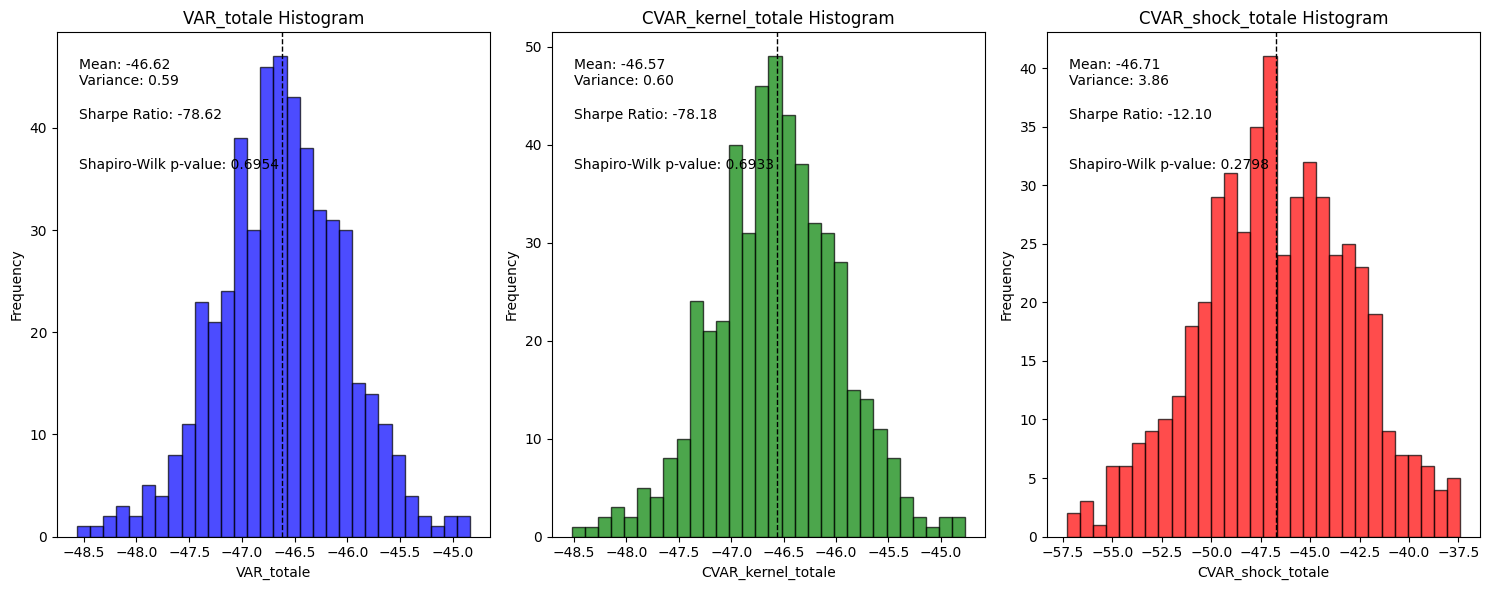

In [6]:

def plot_histograms_with_statistics_and_tests(VAR_totals, CVAR_kernel_totals, CVAR_shock_totals):
    plt.figure(figsize=(15, 6))
    
    # Plotting VAR_totals histogram with statistics and tests
    plt.subplot(1, 3, 1)
    plt.hist(VAR_totals, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(VAR_totals), color='k', linestyle='dashed', linewidth=1)
    plt.text(0.05, 0.95, f"Mean: {np.mean(VAR_totals):.2f}\nVariance: {np.sqrt((np.var(VAR_totals))):.2f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    # Calcul du ratio de Sharpe
    sharpe_ratio_VAR = np.mean(VAR_totals) / np.std(VAR_totals)
    plt.text(0.05, 0.85, f"Sharpe Ratio: {sharpe_ratio_VAR:.2f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    # Test de Shapiro-Wilk
    _, shapiro_p_VAR = shapiro(VAR_totals)
    plt.text(0.05, 0.75, f"Shapiro-Wilk p-value: {shapiro_p_VAR:.4f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    plt.title('VAR_totale Histogram')
    plt.xlabel('VAR_totale')
    plt.ylabel('Frequency')
    
    # Plotting CVAR_kernel_totals histogram with statistics and tests
    plt.subplot(1, 3, 2)
    plt.hist(CVAR_kernel_totals, bins=30, color='green', alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(CVAR_kernel_totals), color='k', linestyle='dashed', linewidth=1)
    plt.text(0.05, 0.95, f"Mean: {np.mean(CVAR_kernel_totals):.2f}\nVariance: {np.sqrt((np.var(CVAR_kernel_totals))):.2f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    # Calcul du ratio de Sharpe
    sharpe_ratio_CVAR_kernel = np.mean(CVAR_kernel_totals) / np.std(CVAR_kernel_totals)
    plt.text(0.05, 0.85, f"Sharpe Ratio: {sharpe_ratio_CVAR_kernel:.2f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    # Test de Shapiro-Wilk
    _, shapiro_p_CVAR_kernel = shapiro(CVAR_kernel_totals)
    plt.text(0.05, 0.75, f"Shapiro-Wilk p-value: {shapiro_p_CVAR_kernel:.4f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    plt.title('CVAR_kernel_totale Histogram')
    plt.xlabel('CVAR_kernel_totale')
    plt.ylabel('Frequency')
    
    # Plotting CVAR_shock_totals histogram with statistics and tests
    plt.subplot(1, 3, 3)
    plt.hist(CVAR_shock_totals, bins=30, color='red', alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(CVAR_shock_totals), color='k', linestyle='dashed', linewidth=1)
    plt.text(0.05, 0.95, f"Mean: {np.mean(CVAR_shock_totals):.2f}\nVariance: {np.sqrt(np.var(CVAR_shock_totals)):.2f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    # Calcul du ratio de Sharpe
    sharpe_ratio_CVAR_shock = np.mean(CVAR_shock_totals) / np.std(CVAR_shock_totals)
    plt.text(0.05, 0.85, f"Sharpe Ratio: {sharpe_ratio_CVAR_shock:.2f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    # Test de Shapiro-Wilk
    _, shapiro_p_CVAR_shock = shapiro(CVAR_shock_totals)
    plt.text(0.05, 0.75, f"Shapiro-Wilk p-value: {shapiro_p_CVAR_shock:.4f}", transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top')
    plt.title('CVAR_shock_totale Histogram')
    plt.xlabel('CVAR_shock_totale')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
plot_histograms_with_statistics_and_tests(VAR_totals, CVAR_kernel_totals, CVAR_shock_totals)

In [5]:
import numpy as np
from scipy.stats import norm

def kernel_function(x, kernel_type="gaussian"):
    if kernel_type == "square":
        return np.where(np.abs(x) <= 1, 0.5, 0)
    elif kernel_type == "triangle":
        return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)
    elif kernel_type == "gaussian":
        return norm.pdf(x)
    else:
        raise ValueError("Unsupported kernel type")

def calculate_VaR(PnL_total, confidence_level=0.95):
    return np.percentile(PnL_total, 100 * (1 - confidence_level))

def calculate_es(pnl_list, beta, lets_go = False):
    var_beta = np.percentile(pnl_list, 100 * (1 - beta))
    pnl_tail = [x for x in pnl_list if x <= var_beta]
    if lets_go:
        var_beta = np.percentile(np.sum(PnL_matrix, axis=1), 100 * (1 - beta))
        pnl_tail = [x for x in pnl_list if x <= var_beta]
        print(var_beta)
    return np.mean(pnl_tail)

def calculate_CVARi(PnL_matrix, confidence_level=0.95, kernel_type="gaussian", bandwidth=1.0):
    n_scenarios, n_components = PnL_matrix.shape
    PnL_total = np.sum(PnL_matrix, axis=1)
    VaR = calculate_VaR(PnL_total, confidence_level)
    distances = (PnL_total - VaR) / bandwidth
    weights = kernel_function(distances, kernel_type)
    weights /= np.sum(weights)
    CVARi = np.zeros(n_components)
    for i in range(n_components):
        CVARi[i] = np.sum(weights * PnL_matrix[:, i])
    return CVARi, VaR

def calculate_es_individual_from_beta(pnl_matrix, beta):
    _, num_components = pnl_matrix.shape
    es_list = np.zeros(num_components)
    var_beta = np.percentile(np.sum(pnl_matrix, axis=1), 100 * (1 - beta))  # VAR_beta
    
    pnl_filtered_indices = np.sum(pnl_matrix, axis=1) <= var_beta
    for i in range(num_components):
        pnl_component = pnl_matrix[pnl_filtered_indices, i]
        pnl_component_sorted = np.sort(pnl_component)
        
        es_component = np.mean(pnl_component_sorted)
        es_list[i] = es_component
        
    return es_list

def find_beta_for_es_equals_var(pnl_list, alpha, tol=1e-5):
    target_var = calculate_var(pnl_list, alpha)
    alpha = 1 - alpha
    #print(target_var)
    low_beta = 0
    high_beta = 4*alpha#pour commencer de manière plus efficace la dichotomie
    while high_beta - low_beta > tol:
        mid_beta = (low_beta + high_beta) / 2
        es_mid_beta = calculate_es(pnl_list, 1-mid_beta)
        if es_mid_beta > target_var:
            high_beta = mid_beta
        else:
            low_beta = mid_beta
    #print(es_mid_beta)
    return (low_beta + high_beta) / 2

def Var_i_list(PnL_matrix,confidence_level):
    _,c = np.shape(PnL_matrix)
    return [calculate_VaR(PnL_matrix[:, i], confidence_level) for i in range(c)]

# Example usage
PnL_matrix = np.random.normal(0, 1, (1000, 5))  # Example PnL data for 5 components over 1000 scenarios
confidence_level = 0.95
kernel_type = "gaussian"
bandwidth = 0.1
beta_global = find_beta_for_es_equals_var(np.sum(PnL_matrix, axis=1), confidence_level)
ES = calculate_es(np.sum(PnL_matrix, axis=1), 1-beta_global)
VAR_BETA = calculate_VaR(np.sum(PnL_matrix, axis=1), confidence_level=1-beta_global)
var_list = Var_i_list(PnL_matrix,confidence_level)
CVARi, VaR = calculate_CVARi(PnL_matrix, confidence_level, kernel_type, bandwidth)
VaR2 = calculate_VaR(np.sum(PnL_matrix, axis=1), confidence_level)
es_list = calculate_es_individual_from_beta(PnL_matrix, 1-beta_global)
print(f"VaR: {VaR}")
print(f"ES : {ES}")
#print(f"VaRi : {var_list}")
print(f"sum CVARi: {sum(CVARi)}")
print(f"CVARi: {CVARi}")
print(f"sum ESi : {sum(es_list)}")
print(f"ESi : {es_list}")



VaR: -3.6490359825790333
ES : -3.6434037623421007
sum CVARi: -3.6391494827652497
CVARi: [-0.49937203 -0.81552442 -0.72539473 -0.86542863 -0.73342967]
sum ESi : -3.6434037623421003
ESi : [-0.76842007 -0.78709369 -0.62005745 -0.64305907 -0.82477347]


In [104]:
import numpy as np
#f(confidence = 95) = VaR ===> ES(confidence_level_prime) = VaR ==> confidence_level_prime ?
def calculate_es2(pnl_list, beta):
    var_beta = np.percentile(pnl_list, 100 * (1 - beta))
    pnl_tail = [x for x in pnl_list if x <= var_beta]
    return np.mean(pnl_tail)
# Exemple de génération de PnL (Profit and Loss) simulé
np.random.seed(42)  # Pour rendre les résultats reproductibles
PnL_matrix = np.random.normal(0, 1, 1000)  # Exemple avec 1000 échantillons

# Calcul de la VaR à 95%
def calculate_var(PnL_matrix, confidence_level=0.95):
    return np.percentile(PnL_matrix, 100 * (1 - confidence_level))

var_95 = calculate_var(PnL_matrix)
print(f"VaR à 95% : {var_95:.2f}")

# Calcul de l'ES pour un y donné (par exemple 0.05 pour correspondre à 95% de confiance)
y = 1- 0.1341#0.967
es_95 = calculate_es1(PnL_matrix, y)
print(f"Expected Shortfall (ES) pour y={y} : {es_95:.2f}")


VaR à 95% : -1.53
Expected Shortfall (ES) pour y=0.8659 : -1.53


In [103]:
import numpy as np

def calculate_var(PnL_matrix, confidence_level=0.95):
    return np.percentile(PnL_matrix, 100 * (1 - confidence_level))

def calculate_es(pnl_list, beta):
    var_beta = np.percentile(pnl_list, 100 * (1 - beta))
    pnl_tail = [x for x in pnl_list if x <= var_beta]
    return np.mean(pnl_tail)

def find_y_dichotomy(PnL_matrix, target_var, confidence_level=0.95, tol=1e-6):
    alpha = 1 - confidence_level
    max_y = 4 * alpha
    
    # Définition des bornes initiales pour la recherche dichotomique
    left_bound = 0.0
    right_bound = max_y
    
    # Recherche dichotomique
    while right_bound - left_bound > tol:
        mid = (left_bound + right_bound) / 2
        es_mid = calculate_es(PnL_matrix, 1-mid)
        
        if es_mid > target_var:
            right_bound = mid  # La solution est dans la moitié gauche
        else:
            left_bound = mid  # La solution est dans la moitié droite
    
    # La valeur trouvée sera au milieu de l'intervalle restant
    return (left_bound + right_bound) / 2

# Exemple de génération de PnL (Profit and Loss) simulé
np.random.seed(42)
PnL_matrix = np.random.normal(0, 1, 1000)

# Calcul de la VaR à 95%
var_95 = calculate_var(PnL_matrix)
print(f"VaR à 95% : {var_95:.2f}")

# Trouver y tel que ES(y) = var_95 avec une plage de 0 à 4 * (1 - 0.95) en utilisant la méthode de la dichotomie
y_solution = find_y_dichotomy(PnL_matrix, var_95, confidence_level=0.95)
print(f"y trouvé avec dichotomie : {y_solution:.4f}")


VaR à 95% : -1.53
y trouvé avec dichotomie : 0.1341


# PLAYGROUND

In [24]:
import numpy as np
from scipy.stats import gaussian_kde, shapiro, kstest, norm,qmc
import matplotlib.pyplot as plt
import math
import time

# Fonctions existantes
def kernel_function(x, num_simulations,kernel_type="gaussian"):
    if kernel_type == "square":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, 1/(2*bandwidth), 0)
    elif kernel_type == "triangle":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, (1 - np.abs(x_scaled))/bandwidth, 0)
    elif kernel_type == "gaussian":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        stdev = bandwidth/math.sqrt(6)
        x_scaled = x / bandwidth
        return norm.pdf(x,scale=bandwidth/math.sqrt(6))
    elif kernel_type == "epanechnikov":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, 3 / (4 * bandwidth) * (1 - x_scaled**2), 0)
    elif kernel_type == "quartic":
        bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        x_scaled = x / bandwidth
        return np.where(np.abs(x_scaled) <= 1, 15 / (16 * bandwidth) * (1 - x_scaled**2)**2, 0)
    else:
        raise ValueError("Unsupported kernel type")

def calculate_VaR(PnL_total, confidence_level=0.95):
    return np.percentile(PnL_total, (1 - confidence_level)* 100)

def calculate_es(pnl_list, beta, lets_go=False):
    var_beta = np.percentile(pnl_list, (1 - beta)* 100)
    pnl_tail = [x for x in pnl_list if x <= var_beta]
    #print("ES",len(pnl_tail))
    return np.mean(pnl_tail)

def calculate_CVARi(PnL_matrix,num_traj,confidence_level=0.95, kernel_type="gaussian"):
    n_scenarios, n_components = PnL_matrix.shape
    PnL_total = np.sum(PnL_matrix, axis=1)
    VaR = calculate_VaR(PnL_total, confidence_level)
    bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
    distances = (PnL_total - VaR)
    #if kernel_type == "triangle":
        #bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
        #distances = (PnL_total - VaR) / bandwidth
    weights = kernel_function(distances,num_traj,kernel_type)
    weights /= np.sum(weights)
    #print(len([weight for weight in weights if not weight == 0])) for 10k traj : 3033 gaussian, 890 for triangle and square
    CVARi = np.zeros(n_components)
    for i in range(n_components):
        CVARi[i] = np.sum(weights * PnL_matrix[:, i])
    return CVARi, VaR

def extract_scenarios(PnL_matrix, confidence_level=0.95):
    n_scenarios, n_components = PnL_matrix.shape
    PnL_total = np.sum(PnL_matrix, axis=1)
    VaR = calculate_VaR(PnL_total, confidence_level)
    scenario_indices = np.where(PnL_total == VaR)[0]
    if len(scenario_indices) == 0:
        closest_index = np.argmin(np.abs(PnL_total - VaR))
        scenario_indices = [closest_index]
    PnL_scenarios = PnL_matrix[scenario_indices, :]
    return PnL_scenarios,VaR

def calculate_es_individual_from_beta(pnl_matrix, beta):
    _, num_components = pnl_matrix.shape
    es_list = np.zeros(num_components)
    var_beta = np.percentile(np.sum(pnl_matrix, axis=1), (1 - beta)* 100)  # VAR_beta
    
    pnl_filtered_indices = np.sum(pnl_matrix, axis=1) <= var_beta
    for i in range(num_components):
        pnl_component = pnl_matrix[pnl_filtered_indices, i]
        pnl_component_sorted = np.sort(pnl_component)
        
        es_component = np.mean(pnl_component_sorted)
        es_list[i] = es_component
        
    return es_list

def find_beta_for_es_equals_var(pnl_list, alpha, tol=1e-5):
    target_var = calculate_VaR(pnl_list, alpha)
    alpha = 1 - alpha
    #print(target_var)
    low_beta = 0
    high_beta = 4*alpha#pour commencer de manière plus efficace la dichotomie
    while high_beta - low_beta > tol:
        mid_beta = (low_beta + high_beta) / 2
        es_mid_beta = calculate_es(pnl_list, 1-mid_beta)
        if es_mid_beta > target_var:
            high_beta = mid_beta
        else:
            low_beta = mid_beta
    return (low_beta + high_beta) / 2

def Var_i_list(PnL_matrix, confidence_level):
    _, c = np.shape(PnL_matrix)
    return [calculate_VaR(PnL_matrix[:, i], confidence_level) for i in range(c)]

def calculate_theoretical_VaR(nominales, covariance_matrix, confidence_level):
    z = norm.ppf(confidence_level)#1.6448536269514722
    portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(covariance_matrix, nominales)))
    VaR_theoretical = -z * portfolio_volatility
    return VaR_theoretical

def calculate_theoretical_CVARi(nominales, covariance_matrix, confidence_level):
    z = norm.ppf(confidence_level)#1.6448536269514722
    portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(covariance_matrix, nominales)))
    marginal_contributions = covariance_matrix @ nominales / portfolio_volatility
    CVARi_theoretical = -z * marginal_contributions
    return CVARi_theoretical*nominales
# Fonction pour calculer la CVaR par méthode du choc de CVaR de 1%
def calculate_cvar_shock(PNL, returns, nominales, confidence_level=0.99, shock=1):#shock>1
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    for i in range(n):#nbr de contrat
        nominales_perturbees = nominales.copy()
        nominales_perturbees[i] *=(1+(shock / 100))
        PNL_perturbé = nominales_perturbees * returns
        VaR_perturbée = calculate_VaR(np.sum(PNL_perturbé, axis=1), confidence_level)
        CVAR_i[i] = (VaR_perturbée - VaR_initial) / (shock / 100)
    return CVAR_i

def calculate_cvar_shock_left(PNL, returns, nominales, confidence_level=0.99, shock=1):#shock>1
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    for i in range(n):#nbr de contrat
        nominales_perturbees = nominales.copy()
        nominales_perturbees[i] *=(1-(shock / 100))
        PNL_perturbé = nominales_perturbees * returns
        VaR_perturbée = calculate_VaR(np.sum(PNL_perturbé, axis=1), confidence_level)
        CVAR_i[i] = (VaR_initial - VaR_perturbée) / (shock / 100)
    return CVAR_i

def calculate_cvar_shock_up_down(PNL, returns, nominales, confidence_level=0.99, shock=1):
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    for i in range(n):  # nombre de contrats
        nominales_perturbees_up = nominales.copy()
        nominales_perturbees_down = nominales.copy()
        nominales_perturbees_up[i] *= (1 + (shock / 100))
        nominales_perturbees_down[i] *= (1 - (shock / 100))
        PNL_perturbe_up = nominales_perturbees_up * returns
        PNL_perturbe_down = nominales_perturbees_down * returns
        VaR_perturbee_up = calculate_VaR(np.sum(PNL_perturbe_up, axis=1), confidence_level)
        VaR_perturbee_down = calculate_VaR(np.sum(PNL_perturbe_down, axis=1), confidence_level)
        CVAR_i[i] = (VaR_perturbee_up - VaR_perturbee_down) / (2 * (shock / 100))
    return CVAR_i

def calculate_cvar_shock_4p(PNL, returns, nominales, confidence_level=0.99, shock=1):
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    delta = shock / 100.0
    for i in range(n):
        nominales_plus_2 = nominales.copy()
        nominales_plus_1 = nominales.copy()
        nominales_moins_1 = nominales.copy()
        nominales_moins_2 = nominales.copy()
        nominales_plus_2[i] *= (1 + 2 * delta)
        nominales_plus_1[i] *= (1 + delta)
        nominales_moins_1[i] *= (1 - delta)
        nominales_moins_2[i] *= (1 - 2 * delta)
        VaR_plus_2 = calculate_VaR((nominales_plus_2 * returns).sum(axis=1), confidence_level)
        VaR_plus_1 = calculate_VaR((nominales_plus_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_1 = calculate_VaR((nominales_moins_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_2 = calculate_VaR((nominales_moins_2 * returns).sum(axis=1), confidence_level)
        CVAR_i[i] = -(VaR_plus_2 - 8 * VaR_plus_1 + 8 * VaR_moins_1 - VaR_moins_2) / (12 * delta)
    return CVAR_i

def calculate_coefficients(n):
    k = 2 * n + 1
    coefficients = np.zeros(k)
    for i in range(k):
        coeff = 0
        for j in range(k):
            if i != j:
                coeff += (-1) ** (i + j) / (i - j)
        coefficients[i] = coeff
    coefficients /= np.sum(np.abs(coefficients))  # Normalisation
    fractions = [Fraction(c).limit_denominator() for c in coefficients]
    formatted_fractions = [f"{frac.numerator}/{frac.denominator}" if frac.denominator != 1 else str(frac.numerator) for frac in fractions]
    print("Coefficients:", formatted_fractions)
    return coefficients
def calculate_cvar_shock_6p(PNL, returns, nominales, confidence_level=0.99, shock=1):
    VaR_initial = calculate_VaR(PNL.sum(axis=1), confidence_level)
    n = len(nominales)
    CVAR_i = np.zeros(n)
    delta = shock / 100.0
    for i in range(n):
        nominales_plus_3 = nominales.copy()
        nominales_plus_2 = nominales.copy()
        nominales_plus_1 = nominales.copy()
        nominales_moins_1 = nominales.copy()
        nominales_moins_2 = nominales.copy()
        nominales_moins_3 = nominales.copy()
        nominales_plus_3[i] *= (1 + 3 * delta)
        nominales_plus_2[i] *= (1 + 2 * delta)
        nominales_plus_1[i] *= (1 + delta)
        nominales_moins_1[i] *= (1 - delta)
        nominales_moins_2[i] *= (1 - 2 * delta)
        nominales_moins_3[i] *= (1 - 3 * delta)
        VaR_plus_3 = calculate_VaR((nominales_plus_3 * returns).sum(axis=1), confidence_level)
        VaR_plus_2 = calculate_VaR((nominales_plus_2 * returns).sum(axis=1), confidence_level)
        VaR_plus_1 = calculate_VaR((nominales_plus_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_1 = calculate_VaR((nominales_moins_1 * returns).sum(axis=1), confidence_level)
        VaR_moins_2 = calculate_VaR((nominales_moins_2 * returns).sum(axis=1), confidence_level)
        VaR_moins_3 = calculate_VaR((nominales_moins_3 * returns).sum(axis=1), confidence_level)
        CVAR_i[i] = (VaR_plus_3 - 9 * VaR_plus_2 + 45 * VaR_plus_1 - 45 * VaR_moins_1 + 9 * VaR_moins_2 - VaR_moins_3) / (60 * delta)
    return CVAR_i

def calculate_cvar_shock_np(PNL, returns, nominales, confidence_level=0.99, shock=1, n=2):
    coefficients = calculate_coefficients(n)
    delta = shock / 100.0
    k = 2 * n + 1
    CVAR_i = np.zeros(len(nominales))
    for i in range(len(nominales)):
        perturbed_VaR = 0.0
        for j in range(k):
            perturbation = (n - j) * delta
            nominales_perturbed = nominales.copy()
            if j < n:
                nominales_perturbed[i] *= (1 + (j + 1) * delta)
            else:
                nominales_perturbed[i] *= (1 - (j - n) * delta)
            VaR_perturbed = calculate_VaR((nominales_perturbed * returns).sum(axis=1), confidence_level)
            perturbed_VaR += coefficients[j] * VaR_perturbed
        CVAR_i[i] = perturbed_VaR / delta
    return CVAR_i


# Exemple d'utilisation
n_components = 4
num_simulations = 10000  # Nombre de trajectoire
volatility = 0.1*math.sqrt(0.5)  # Exemple de volatilité (10% annuel à 6 mois)
rho = 0.38  # Coefficient de corrélation unique
confidence_level = 0.99
nominales = np.array([100,100,50,50])# Nominales des actifs
volatilities = np.array([0.2,0.1,0.2,0.1])

# Matrice de corrélation
corr_matrix = np.full((n_components, n_components), rho)
np.fill_diagonal(corr_matrix, 1)
# Vecteur de poids des actifs
weights = np.ones(n_components) / n_components
# Génération des rendements aléatoires
mean_returns = np.zeros(n_components)
cov_matrix = np.diag(volatilities) @ corr_matrix @ np.diag(volatilities)
#volatilité sur tout le portefeuille
portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(cov_matrix, nominales)))
returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)
#returns = np.exp(returns)
#skew_params = np.array([5, -3, 2,2,2])#np.ones(5)*0
#returns = generate_skewed_multivariate(mean_returns, cov_matrix, num_simulations, skew_params)
# Calcul des P&L pour chaque contrat
PnL_matrix = nominales * returns

# P&L total sur tous les contrats
PnL_total = np.sum(PnL_matrix, axis=1)
# Calculer VaR et CVaR empiriques
beta_global = find_beta_for_es_equals_var(PnL_total, confidence_level)
ES = calculate_es(PnL_total, 1 - beta_global)
VaR_empirical = calculate_VaR(PnL_total, confidence_level)
CVARi, VaR = calculate_CVARi(PnL_matrix,num_simulations, confidence_level, kernel_type="gaussian")
CVARi_shock = calculate_cvar_shock(PnL_matrix, returns, nominales, confidence_level, shock=5)#shock de 2%, très bizarre, je ne peux pas faire de shock plus bas
CVARi_shock_left = calculate_cvar_shock_left(PnL_matrix, returns, nominales, confidence_level, shock=5)#shock de 2%, très bizarre, je ne peux pas faire de shock plus bas
CVARi_shock_up_down = calculate_cvar_shock_up_down(PnL_matrix, returns, nominales, confidence_level, shock=2)#shock de 2%, très bizarre, je ne peux pas faire de shock plus bas
CVARi_shock_4p = calculate_cvar_shock_4p(PnL_matrix, returns, nominales, confidence_level, shock=12)#shock de 2%, très bizarre, je ne peux pas faire de shock plus bas
CVARi_shock_6p = calculate_cvar_shock_6p(PnL_matrix, returns, nominales, confidence_level, shock=60)

es_list = calculate_es_individual_from_beta(PnL_matrix, 1 - beta_global)
CVARi_extractio, VaR_extratio = extract_scenarios(PnL_matrix,confidence_level)
CVARi_triangle, VaR_triangle = calculate_CVARi(PnL_matrix,num_simulations, confidence_level, kernel_type="triangle")
CVARi_rectangle, VaR_rectangle = calculate_CVARi(PnL_matrix,num_simulations, confidence_level, kernel_type="square")
CVARi_epanechnikov, VaR_epanechnikov = calculate_CVARi(PnL_matrix, num_simulations, confidence_level, kernel_type="epanechnikov")
CVARi_quartic, VaR_quartic = calculate_CVARi(PnL_matrix, num_simulations, confidence_level, kernel_type="quartic")

# Calculer VaR et CVaR théoriques
VaR_theoretical = calculate_theoretical_VaR(nominales, cov_matrix, confidence_level)
CVARi_theoretical = calculate_theoretical_CVARi(nominales, cov_matrix, confidence_level)

print(f"VaR (Empirical): {VaR_empirical}")
print(f"ES (Empirical): {ES}")
print(f"Sum CVARi shock (Empirical): {sum(CVARi_shock)}")
print(f"CVARi shock (Empirical): {CVARi_shock}")#à rebaser
print(f"Sum CVARi shock left: {sum(CVARi_shock_left)}")#CVARi_shock_left
print(f"CVARi shock left: {CVARi_shock_left}")#à rebaser
print(f"Sum CVARi shock ud: {sum(CVARi_shock_up_down)}")
print(f"CVARi shock ud: {CVARi_shock_up_down}")#à rebaser
print(f"Sum CVARi shock 4p: {sum(CVARi_shock_4p)}")
print(f"CVARi shock 4p: {CVARi_shock_4p}")#à rebaser
print(f"Sum CVARi shock 6p: {sum(CVARi_shock_6p)}")
print(f"CVARi shock 6p: {CVARi_shock_6p}")#à rebaser
print(f"Sum CVARi (Empirical): {sum(CVARi)}")
print(f"CVARi (Empirical): {CVARi}")#à rebaser
print(f"Sum ESi (Empirical): {sum(es_list)}")
print(f"ESi (Empirical): {es_list}")
print(f"Sum CVARi extration: {sum(CVARi_extractio[0])}")
print(f"CVARi extration: {CVARi_extractio[0]}")
print(f"Sum CVARi triangle: {sum(CVARi_triangle)}")
print(f"CVARi triangle: {CVARi_triangle}")
print(f"Sum CVARi rectangle: {sum(CVARi_rectangle)}")
print(f"CVARi rectangle: {CVARi_rectangle}")
print(f"Sum CVARi Épanechnikov: {sum(CVARi_epanechnikov)}")
print(f"CVARi Épanechnikov: {CVARi_epanechnikov}")
print(f"Sum CVARi Quartic: {sum(CVARi_quartic)}")
print(f"CVARi Quartic: {CVARi_quartic}")

print(f"VaR (Theoretical): {VaR_theoretical}")
print(f"Sum CVARi (Theoretical): {sum(CVARi_theoretical)}")
print(f"CVARi (Theoretical): {CVARi_theoretical}")


VaR (Empirical): -78.20873115121225
ES (Empirical): -78.25487925164894
Sum CVARi shock (Empirical): -74.64756255279582
CVARi shock (Empirical): [-34.88593186 -16.85925291 -15.43832951  -7.46404828]
Sum CVARi shock left: -89.80972613249577
CVARi shock left: [-35.89230253 -22.07899341 -20.40977515 -11.42865505]
Sum CVARi shock ud: -88.17279060865992
CVARi shock ud: [-32.12166564 -20.17619416 -24.6946997  -11.1802311 ]
Sum CVARi shock 4p: -76.65346068832667
CVARi shock 4p: [-38.25611498 -15.21639828 -16.72138847  -6.45955896]
Sum CVARi shock 6p: -78.96247746491096
CVARi shock 6p: [-38.87080271 -16.18392654 -16.78009189  -7.12765633]
Sum CVARi (Empirical): -75.95507394124422
CVARi (Empirical): [-38.57637691 -15.70162369 -15.17803287  -6.49904048]
Sum ESi (Empirical): -78.25487925164894
ESi (Empirical): [-40.10472708 -15.710018   -15.8357756   -6.60435857]
Sum CVARi extration: -78.20674546075497
CVARi extration: [-14.13458216 -25.93722607 -26.88618457 -11.24875266]
Sum CVARi triangle: -75.9

# LANCEUR DE LA SIMULATION DE LA MAQUETTE COMPLETE

In [11]:
#Parameter of the model
num_traj = 10000  # Nombre de trajectoire
volatility = 0.1*math.sqrt(0.5)  # Exemple de volatilité (10% annuel à 6 mois)
rho = 0.38  # Coefficient de corrélation unique
confidence_level = 0.99
nominales = np.array([100,100,50,50])# Nominales des actifs
volatilities = np.array([0.2,0.1,0.2,0.1])
n_components = len(nominales)
# Matrice de corrélation
corr_matrix = np.full((n_components, n_components), rho)
np.fill_diagonal(corr_matrix, 1)
weights = np.ones(n_components) / n_components# Vecteur de poids des actifs
mean_returns = np.zeros(n_components)# Génération des rendements aléatoires centrées en 0
cov_matrix = np.diag(volatilities) @ corr_matrix @ np.diag(volatilities)
portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(cov_matrix, nominales)))#volatilité sur tout le portefeuille
VaR_theoretical = calculate_theoretical_VaR(nominales, cov_matrix, confidence_level)
CVARi_theoretical = calculate_theoretical_CVARi(nominales, cov_matrix, confidence_level)
print(VaR_theoretical,CVARi_theoretical,portfolio_volatility)

-79.13003132016233 [-40.3515285  -15.93543414 -15.93543414  -6.90763454] 34.0147027033899


In [30]:
bandwidth = 2.6*portfolio_volatility/(num_simulations)**(1/5)
bandwidth

14.016514397129733

In [26]:
# Initialisation des listes pour stocker les résultats
VaR_empirical_list = []
ES_empirical_list = []
Sum_CVARi_shock_list = []
CVARi_shock_first_list = []
Sum_CVARi_shock_left_list = []
CVARi_shock_left_first_list = []
Sum_CVARi_shock_ud_list = []
Sum_CVARi_shock_4p_list = []
CVARi_shock_4p_first_list = []
Sum_CVARi_shock_6p_list = []
CVARi_shock_6p_first_list = []
CVARi_shock_ud_first_list = []
Sum_CVARi_kernel_list = []
CVARi_kernel_first_list = []
Sum_ESi_list = []
ESi_first_list = []
Sum_CVARi_extractio_list = []
CVARi_extractio_first_list = []
Sum_CVARi_triangle_list = []
CVARi_triangle_first_list = []
Sum_CVARi_rectangle_list = []
CVARi_rectangle_first_list = []
Sum_CVARi_epanechnikov_list = []
CVARi_epanechnikov_first_list = []
Sum_CVARi_quartic_list = []
CVARi_quartic_first_list = []
VaR_ind_list = []
Sum_VaR_ind_list=[]
#RECORD rebased
gaussian_list_rebased=[]
triangle_list_rebased=[]
epanechnikov_list_rebased=[]
quartic_list_rebased=[]
shock_ud_list_rebased=[]
gaussian_sum_rebased=[]
triangle_sum_rebased=[]
epanechnikov_sum_rebased=[]
quartic_sum_rebased=[]
shock_ud_sum_rebased=[]
import time
depart = time.time()
# Initialisation des listes pour stocker les temps d'exécution
time_cvar_shock = []
time_CVARi = []
time_es_individual = []
num_traj = 10000
confidence_level = 0.99
for _ in range(1000):#K = nb de simulation
    # Génération des rendements
    returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_traj)#N = 10000 trajectoires

    # Calcul des P&L pour chaque contrat
    PnL_matrix = nominales * returns#@ produit matriciel et * produit terme à terme

    # P&L total sur tous les contrats
    PnL_total = np.sum(PnL_matrix, axis=1)

    # Calculer VaR et CVaR empiriques
    VaR_empirical = calculate_VaR(PnL_total, confidence_level)
    
    # Mesurer le temps pour calculate_CVARi
    start_time = time.time()
    CVARi, VaR = calculate_CVARi(PnL_matrix,num_traj, confidence_level, kernel_type="gaussian")
    time_CVARi.append(time.time() - start_time)
    
    # Mesurer le temps pour calculate_cvar_shock
    start_time = time.time()
    CVARi_shock_up_down = calculate_cvar_shock_up_down(PnL_matrix, returns, nominales, confidence_level, shock=10)
    time_cvar_shock.append(time.time() - start_time)
    CVARi_shock_left = calculate_cvar_shock_left(PnL_matrix, returns, nominales, confidence_level, shock=10)
    CVARi_shock = calculate_cvar_shock(PnL_matrix, returns, nominales, confidence_level, shock=10)  # Shock de 5%
    CVARi_shock_4p = calculate_cvar_shock_6p(PnL_matrix, returns, nominales, confidence_level, shock=12)#12
    CVARi_shock_6p = calculate_cvar_shock_6p(PnL_matrix, returns, nominales, confidence_level, shock=59)#60
    # Mesurer le temps pour calculate_es_individual_from_beta
    start_time = time.time()
    beta_global = find_beta_for_es_equals_var(PnL_total, confidence_level)
    ES = calculate_es(PnL_total, 1 - beta_global)
    es_list = calculate_es_individual_from_beta(PnL_matrix, 1 - beta_global)
    time_es_individual.append(time.time() - start_time)

    CVARi_extractio, VaR_extratio = extract_scenarios(PnL_matrix, confidence_level)
    CVARi_triangle, VaR_triangle = calculate_CVARi(PnL_matrix,num_traj, confidence_level, kernel_type="triangle")
    CVARi_rectangle, VaR_rectangle = calculate_CVARi(PnL_matrix,num_traj, confidence_level, kernel_type="square")
    CVARi_epanechnikov, VaR_epanechnikov = calculate_CVARi(PnL_matrix, num_traj, confidence_level, kernel_type="epanechnikov")
    CVARi_quartic, VaR_quartic = calculate_CVARi(PnL_matrix, num_traj, confidence_level, kernel_type="quartic")

    VARi_individuel = Var_i_list(PnL_matrix,confidence_level)

    #REBASED: it's useless to rebased ESi
    CVARi_gaussian_rebased = CVARi * VaR_empirical / sum(CVARi)
    CVARi_triangle_rebased = CVARi_triangle * VaR_empirical / sum(CVARi_triangle)
    CVARi_shock_up_down_rebased = CVARi_shock_up_down * VaR_empirical / sum(CVARi_shock_up_down)
    CVARi_epanechnikov_rebased = CVARi_epanechnikov * VaR_empirical / np.sum(CVARi_epanechnikov)
    CVARi_quartic_rebased = CVARi_quartic * VaR_empirical / np.sum(CVARi_quartic)

    #RECORD rebased first CVAR_i=0
    gaussian_list_rebased.append(CVARi_gaussian_rebased[0])
    triangle_list_rebased.append(CVARi_triangle_rebased[0])
    shock_ud_list_rebased.append(CVARi_shock_up_down_rebased[0])
    epanechnikov_list_rebased.append(CVARi_epanechnikov_rebased[0])
    quartic_list_rebased.append(CVARi_quartic_rebased[0])
    #RECORD sum
    gaussian_sum_rebased.append(sum(CVARi_gaussian_rebased))
    triangle_sum_rebased.append(sum(CVARi_triangle_rebased))
    shock_ud_sum_rebased.append(sum(CVARi_shock_up_down_rebased))
    epanechnikov_sum_rebased.append(np.sum(CVARi_epanechnikov_rebased))
    quartic_sum_rebased.append(np.sum(CVARi_quartic_rebased))

    # Stockage des valeurs pour chaque simulation
    VaR_empirical_list.append(VaR_empirical)
    ES_empirical_list.append(ES)
    Sum_CVARi_shock_list.append(np.sum(CVARi_shock))
    CVARi_shock_first_list.append(CVARi_shock[0])
    Sum_CVARi_shock_left_list.append(np.sum(CVARi_shock_left))
    CVARi_shock_left_first_list.append(CVARi_shock_left[0])
    Sum_CVARi_shock_ud_list.append(np.sum(CVARi_shock_up_down))
    CVARi_shock_ud_first_list.append(CVARi_shock_up_down[0])
    Sum_CVARi_shock_4p_list.append(np.sum(CVARi_shock_4p))
    CVARi_shock_4p_first_list.append(CVARi_shock_4p[0])
    Sum_CVARi_shock_6p_list.append(np.sum(CVARi_shock_6p))
    CVARi_shock_6p_first_list.append(CVARi_shock_6p[0])
    Sum_CVARi_kernel_list.append(np.sum(CVARi))
    CVARi_kernel_first_list.append(CVARi[0])
    Sum_ESi_list.append(np.sum(es_list))
    ESi_first_list.append(es_list[0])

    Sum_CVARi_extractio_list.append(np.sum(CVARi_extractio))
    CVARi_extractio_first_list.append(CVARi_extractio[0])
    Sum_CVARi_triangle_list.append(np.sum(CVARi_triangle))
    CVARi_triangle_first_list.append(CVARi_triangle[0])
    Sum_CVARi_rectangle_list.append(np.sum(CVARi_rectangle))
    CVARi_rectangle_first_list.append(CVARi_rectangle[0])
    Sum_CVARi_epanechnikov_list.append(np.sum(CVARi_epanechnikov))
    CVARi_epanechnikov_first_list.append(CVARi_epanechnikov[0])
    Sum_CVARi_quartic_list.append(np.sum(CVARi_quartic))
    CVARi_quartic_first_list.append(CVARi_quartic[0])

    Sum_VaR_ind_list.append(sum(VARi_individuel))
    VaR_ind_list.append(VARi_individuel[0])

results = {"CVARi_shock_4p":np.mean(CVARi_shock_4p_first_list),"CVARi_shock_6p":np.mean(CVARi_shock_6p_first_list),"Sum_CVARi_shock_4p":np.mean(Sum_CVARi_shock_4p_list),"Sum_CVARi_shock_6p":np.mean(Sum_CVARi_shock_6p_list),"VaR_empirical": np.mean(VaR_empirical_list),"ES_empirical": np.mean(ES_empirical_list),"Sum_CVARi_shock": np.mean(Sum_CVARi_shock_list),"CVARi_shock": np.mean(CVARi_shock_first_list),"Sum_CVARi_gaussian": np.mean(Sum_CVARi_kernel_list),"CVARi_gaussian": np.mean(CVARi_kernel_first_list),"Sum_ESi": np.mean(Sum_ESi_list),"ESi": np.mean(ESi_first_list),"Sum_CVARi_extractio": np.mean(Sum_CVARi_extractio_list),"CVARi_extractio": np.mean(CVARi_extractio_first_list),"Sum_CVARi_triangle": np.mean(Sum_CVARi_triangle_list),"CVARi_triangle": np.mean(CVARi_triangle_first_list),"Sum_CVARi_rectangle": np.mean(Sum_CVARi_rectangle_list),"CVARi_rectangle": np.mean(CVARi_rectangle_first_list),"Sum_CVARi_epanechnikov": np.mean(Sum_CVARi_epanechnikov_list),"CVARi_epanechnikov": np.mean(CVARi_epanechnikov_first_list),"Sum_CVARi_quartic": np.mean(Sum_CVARi_quartic_list),"CVARi_quartic": np.mean(CVARi_quartic_first_list)}

# Affichage des résultats agrégés
print(f"VaR (Empirical): {results['VaR_empirical']}")
print(f"ES: {results['ES_empirical']}")
print(f"Sum CVARi shock: {results['Sum_CVARi_shock']}")
print(f"CVARi shock: {results['CVARi_shock']}")
print(f"Sum CVARi kernel: {results['Sum_CVARi_gaussian']}")
print(f"CVARi kernel: {results['CVARi_gaussian']}")
print(f"Sum ESi: {results['Sum_ESi']}")
print(f"ESi: {results['ESi']}")
print(f"Sum CVARi extraction: {results['Sum_CVARi_extractio']}")
print(f"CVARi extraction: {results['CVARi_extractio']}")
print(f"Sum CVARi triangle: {results['Sum_CVARi_triangle']}")
print(f"CVARi triangle: {results['CVARi_triangle']}")
print(f"Sum CVARi rectangle: {results['Sum_CVARi_rectangle']}")
print(f"CVARi rectangle: {results['CVARi_rectangle']}")
print(f"Sum CVARi Epanechnikov: {results['Sum_CVARi_epanechnikov']}")
print(f"CVARi Epanechnikov: {results['CVARi_epanechnikov']}")
print(f"Sum CVARi Quartic: {results['Sum_CVARi_quartic']}")
print(f"CVARi Quartic: {results['CVARi_quartic']}")
print(f"Execution time: {time.time() - depart} seconds for {num_simulations}")

# Affichage des temps d'exécution
print(f"Temps moyen pour calculate_cvar_shock: {round(np.mean(time_cvar_shock),3)} secondes")
print(f"Temps moyen pour calculate_CVARi: {round(np.mean(time_CVARi),3)} secondes")
print(f"Temps moyen pour calculate_es_individual_from_beta: {round(np.mean(time_es_individual),3)} secondes")

CVARi_triangle_first_list_rebased = list(np.array(CVARi_triangle_first_list) * np.array(VaR_empirical_list)/np.array(Sum_CVARi_triangle_list))
VaR_ind_first_list_rebased = list(np.array(VaR_ind_list) * np.array(VaR_empirical_list)/np.array(Sum_VaR_ind_list))

VaR (Empirical): -79.08862552279903
ES: -79.08788845559515
Sum CVARi shock: -79.53529098139094
CVARi shock: -40.60982205139659
Sum CVARi kernel: -76.93462315894283
CVARi kernel: -39.22220046999998
Sum ESi: -79.08788845559515
ESi: -40.34239038654708
Sum CVARi extraction: -79.08734382317803
CVARi extraction: -19.77183595579451
Sum CVARi triangle: -76.95204494860518
CVARi triangle: -39.23401784181874
Sum CVARi rectangle: -74.97166321904973
CVARi rectangle: -38.24073047171109
Sum CVARi Epanechnikov: -76.54437731437237
CVARi Epanechnikov: -39.029073239364244
Sum CVARi Quartic: -77.25110799937835
CVARi Quartic: -39.381748926524175
Execution time: 36.11478281021118 seconds for 10000
Temps moyen pour calculate_cvar_shock: 0.003 secondes
Temps moyen pour calculate_CVARi: 0.001 secondes
Temps moyen pour calculate_es_individual_from_beta: 0.01 secondes


In [40]:
#Parameter of the model
num_traj = 10000  # Nombre de trajectoire
volatility = 0.1*math.sqrt(0.5)  # Exemple de volatilité (10% annuel à 6 mois)
rho = 0.38  # Coefficient de corrélation unique
confidence_level = 0.95
nominales = np.array([100,100,50,50])# Nominales des actifs
volatilities = np.array([0.2,0.1,0.2,0.1])
n_components = len(nominales)
# Matrice de corrélation
corr_matrix = np.full((n_components, n_components), rho)
np.fill_diagonal(corr_matrix, 1)
weights = np.ones(n_components) / n_components# Vecteur de poids des actifs
mean_returns = np.zeros(n_components)# Génération des rendements aléatoires centrées en 0
cov_matrix = np.diag(volatilities) @ corr_matrix @ np.diag(volatilities)
portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(cov_matrix, nominales)))#volatilité sur tout le portefeuille
VaR_theoretical = calculate_theoretical_VaR(nominales, cov_matrix, confidence_level)
CVARi_theoretical = calculate_theoretical_CVARi(nominales, cov_matrix, confidence_level)
print(VaR_theoretical,CVARi_theoretical)

-55.94920711134692 [-28.53071063 -11.26721284 -11.26721284  -4.8840708 ]


In [220]:
def calculate_statistics(CVARi_list,VaR_list,VaR_theoretical):
    CVARi_sum = np.sum(CVARi_list, axis=1)
    CVARi_0 = np.array([cvar[0] for cvar in CVARi_list])
    mean_sum_CVARi = np.mean(CVARi_sum)
    stdev_CVARi_0 = np.std(CVARi_0)
    mean_CVARi_0 = np.mean(CVARi_0)
    cv_CVARi_0 = abs(stdev_CVARi_0*100 / mean_CVARi_0)
    abs_diff_VaR = np.mean(np.abs(np.array(VaR_list) - CVARi_sum))
    quad_diff_VaR = np.sqrt(np.mean((np.array(VaR_list) - CVARi_sum) ** 2))
    VaR_array_th = np.full_like(CVARi_sum, VaR_theoretical)
    quad_diff_VaR_th = np.sqrt(np.mean((VaR_array_th - CVARi_sum) ** 2))
    return {
        'CVARi_list':CVARi_list,
        'mean_sum_CVARi': mean_sum_CVARi,
        'stdev_CVARi_0': stdev_CVARi_0,
        'mean_CVARi_0': mean_CVARi_0,
        'cv_CVARi_0': cv_CVARi_0,
        'abs_diff_VaR': abs_diff_VaR,
        'quad_diff_VaR': quad_diff_VaR,
        'quad_diff_VaR_th':quad_diff_VaR_th
    }
def simulation(nb_iterations, confidence_level,shock,num_traj,rho):
    VaR_list, shock_list, shock_ud_list, esi_list, extratio_list,gaussian_list,triangle_list,square_list = [],[],[],[],[],[],[],[]
    gaussian_list_rebased,triangle_list_rebased,shock_ud_list_rebased= [],[],[]
    VaR_theoretical = calculate_theoretical_VaR(nominales, cov_matrix, confidence_level)
    CVARi_theoretical = calculate_theoretical_CVARi(nominales, cov_matrix, confidence_level)
    for _ in range(nb_iterations):
        # Génération des rendements
        returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_traj)
        # Calcul des P&L pour chaque contrat
        PnL_matrix = nominales * returns
        # P&L total sur tous les contrats
        PnL_total = np.sum(PnL_matrix, axis=1)
        #RECKON
        VaR_empirical = calculate_VaR(PnL_total, confidence_level)
        CVARi_shock = calculate_cvar_shock(PnL_matrix, returns, nominales, confidence_level, shock)  # Shock de 5%
        CVARi_shock_up_down = calculate_cvar_shock_up_down(PnL_matrix, returns, nominales, confidence_level, shock)#shock de 2%, très bizarre, je ne peux pas faire de shock plus bas
        beta_global = find_beta_for_es_equals_var(PnL_total, confidence_level)
        ES = calculate_es(PnL_total, 1 - beta_global)
        es_list = calculate_es_individual_from_beta(PnL_matrix, 1 - beta_global)
        CVARi_extractio, VaR_extratio = extract_scenarios(PnL_matrix, confidence_level)
        CVARi_gaussian, VaR_gaussian = calculate_CVARi(PnL_matrix,num_traj, confidence_level, kernel_type="gaussian")
        CVARi_triangle, VaR_triangle = calculate_CVARi(PnL_matrix,num_traj, confidence_level, kernel_type="triangle")
        CVARi_rectangle, VaR_rectangle = calculate_CVARi(PnL_matrix,num_traj, confidence_level, kernel_type="square")

        #REBASED: it's useless to rebased ESi
        CVARi_gaussian_rebased = CVARi_gaussian * VaR_empirical / sum(CVARi_gaussian)
        CVARi_triangle_rebased = CVARi_triangle * VaR_empirical / sum(CVARi_triangle)
        CVARi_shock_up_down_rebased = CVARi_shock_up_down * VaR_empirical / sum(CVARi_shock_up_down)
        #RECORD
        VaR_list.append(VaR_empirical)
        shock_list.append(CVARi_shock)
        shock_ud_list.append(CVARi_shock_up_down)
        esi_list.append(es_list)
        extratio_list.append(CVARi_extractio[0])
        gaussian_list.append(CVARi_gaussian)
        triangle_list.append(CVARi_triangle)
        square_list.append(CVARi_rectangle)
        #RECORD rebased
        gaussian_list_rebased.append(CVARi_gaussian_rebased)
        triangle_list_rebased.append(CVARi_triangle_rebased)
        shock_ud_list_rebased.append(CVARi_shock_up_down_rebased)

    shock_stats = calculate_statistics(shock_list,VaR_list,VaR_theoretical)
    shock_ud_stats = calculate_statistics(shock_ud_list,VaR_list,VaR_theoretical)
    esi_stats = calculate_statistics(esi_list,VaR_list,VaR_theoretical)
    extratio_stats = calculate_statistics(extratio_list,VaR_list,VaR_theoretical)
    gaussian_stats = calculate_statistics(gaussian_list,VaR_list,VaR_theoretical)
    triangle_stats = calculate_statistics(triangle_list,VaR_list,VaR_theoretical)
    square_stats = calculate_statistics(square_list,VaR_list,VaR_theoretical)
    #stats rebased
    gaussian_stats_rebased = calculate_statistics(gaussian_list_rebased,VaR_list,VaR_theoretical)
    triangle_stats_rebased = calculate_statistics(triangle_list_rebased,VaR_list,VaR_theoretical)
    shock_ud_stats_rebased = calculate_statistics(shock_ud_list_rebased,VaR_list,VaR_theoretical)
    return {
        'VaR_th_normal':VaR_theoretical,
        'CVARi_th_normal':CVARi_theoretical,
        'VaR_list': VaR_list,
        'shock_stats': shock_stats,
        'shock_ud_stats': shock_ud_stats,
        'esi_stats': esi_stats,
        'extratio_stats': extratio_stats,
        'gaussian_stats': gaussian_stats,
        'triangle_stats': triangle_stats,
        'square_stats': square_stats,
        'rebased gaussian':gaussian_stats_rebased,
        'rebased triangle':triangle_stats_rebased,
        'rebased shock ud':shock_ud_stats_rebased
    }
simulation(2, 0.99,5,10000,rho)


{'VaR_th_normal': -79.13003132016233,
 'CVARi_th_normal': array([-40.3515285 , -15.93543414, -15.93543414,  -6.90763454]),
 'VaR_list': [-80.53467184570476, -78.18640785148862],
 'shock_stats': {'CVARi_list': [array([-37.97775945, -12.17376015,  -7.7242388 ,  -6.95410147]),
   array([-49.06320051, -16.27440683, -12.74058848, -11.62565014])],
  'mean_sum_CVARi': -77.26685291166334,
  'stdev_CVARi_0': 5.542720530855689,
  'mean_CVARi_0': -43.52047997812278,
  'cv_CVARi_0': 12.735890168587176,
  'abs_diff_VaR': 13.611125042989123,
  'quad_diff_VaR': 13.771210909929854,
  'quad_diff_VaR_th': 12.575779490957629},
 'shock_ud_stats': {'CVARi_list': [array([-40.44046075, -15.7593875 , -14.40682032,  -7.62319294]),
   array([-43.45548752, -12.32883329, -15.64581213, -11.37449982])],
  'mean_sum_CVARi': -80.51724712560386,
  'stdev_CVARi_0': 1.5075133856474565,
  'mean_CVARi_0': -41.94797413307768,
  'cv_CVARi_0': 3.5937692267687393,
  'abs_diff_VaR': 3.4615176225150535,
  'quad_diff_VaR': 3.649

In [246]:
nb_trajectoire = np.array([1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000,5000000])#np.arange(1, 1000001, 10000)
cv_CVARi_0_gaussian_sim = []
cv_CVARi_0_triangle_sim = []
cv_CVARi_0_esi_sim = []
cv_CVARi_0_shock_ud_sim = []
sqrt_quad_diff_VaR_gaussian_sim = []
sqrt_quad_diff_VaR_triangle_sim = []
sqrt_quad_diff_VaR_esi_sim = []
sqrt_quad_diff_VaR_shock_ud_sim = []
Var_sim_list = []

cv_CVARi_0_rebased_gaussian = []
cv_CVARi_0_rebased_triangle = []
cv_CVARi_0_rebased_esi = []
cv_CVARi_0_rebased_shock_ud = []
sqrt_quad_diff_VaR_rebased_gaussian = []
sqrt_quad_diff_VaR_rebased_triangle = []
sqrt_quad_diff_VaR_rebased_esi = []
sqrt_quad_diff_VaR_rebased_shock_ud = []

import numpy as np
for nb_traj in nb_trajectoire:
    results = simulation(1,0.99,5,nb_traj,rho)
    Var_sim_list.append(np.mean(results['VaR_list']))
    cv_CVARi_0_gaussian_sim.append(results['gaussian_stats']['cv_CVARi_0'])
    cv_CVARi_0_triangle_sim.append(results['triangle_stats']['cv_CVARi_0'])
    cv_CVARi_0_esi_sim.append(results['esi_stats']['cv_CVARi_0'])
    cv_CVARi_0_shock_ud_sim.append(results['shock_ud_stats']['cv_CVARi_0'])
    sqrt_quad_diff_VaR_gaussian_sim.append(results['gaussian_stats']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_triangle_sim.append(results['triangle_stats']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_esi_sim.append(results['esi_stats']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_shock_ud_sim.append(results['shock_ud_stats']['quad_diff_VaR_th'])
    # Ajouter les statistiques recalées
    cv_CVARi_0_rebased_gaussian.append(results['rebased gaussian']['cv_CVARi_0'])
    cv_CVARi_0_rebased_triangle.append(results['rebased triangle']['cv_CVARi_0'])
    cv_CVARi_0_rebased_esi.append(results['esi_stats']['cv_CVARi_0'])
    cv_CVARi_0_rebased_shock_ud.append(results['rebased shock ud']['cv_CVARi_0'])
    
    sqrt_quad_diff_VaR_rebased_gaussian.append(results['rebased gaussian']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_rebased_triangle.append(results['rebased triangle']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_rebased_esi.append(results['esi_stats']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_rebased_shock_ud.append(results['rebased shock ud']['quad_diff_VaR_th'])


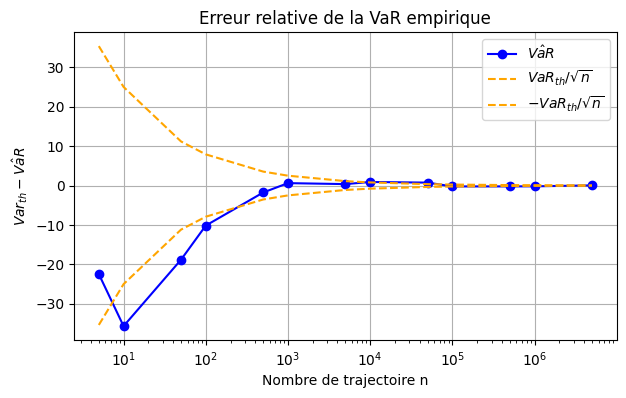

In [247]:
# Tracer les résultats pour sqrt_quad_diff_VaR
plt.figure(figsize=(7, 4))
plt.plot(nb_trajectoire[1:], [-79.13003132016233- Var for Var in Var_sim_list[1:]], label=r"$V\hat{a}R$", marker='o', color='blue')#VaR (Theoretical): -79.13003132016233 à alpha = 99
#plt.axhline(y=-79.13003132016233, color='k', linestyle='--', label='VaR théorique')
# Fonctions décroissante et croissante
C=  79.13003132016233
plt.plot(nb_trajectoire[1:], C / np.sqrt(nb_trajectoire[1:]), label=r'$VaR_{th}/\sqrt{n}$', linestyle='--', color='orange')
plt.plot(nb_trajectoire[1:], -C / np.sqrt(nb_trajectoire[1:]), label=r'$-VaR_{th}/\sqrt{n}$', linestyle='--', color='orange')

plt.xscale('log')
plt.xlabel('Nombre de trajectoire n')
plt.ylabel('$Var_{th} - V\hat{a}R$')
plt.title('Erreur relative de la VaR empirique')
plt.legend()
plt.grid(True)
plt.show()

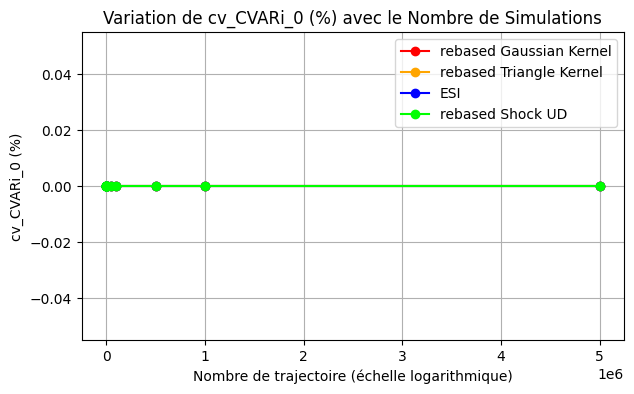

In [248]:
plt.figure(figsize=(7, 4))
plt.plot(nb_trajectoire[1:], cv_CVARi_0_rebased_gaussian[1:], label='rebased Gaussian Kernel', marker='o', color='red')
plt.plot(nb_trajectoire[1:], cv_CVARi_0_rebased_triangle[1:], label='rebased Triangle Kernel', marker='o', color='orange')
plt.plot(nb_trajectoire[1:], cv_CVARi_0_esi_sim[1:], label='ESI', marker='o', color='blue')
plt.plot(nb_trajectoire[1:], cv_CVARi_0_rebased_shock_ud[1:], label='rebased Shock UD', marker='o', color='#00FF00')  # Vert flashy
#plt.xscale('log')
plt.xlabel('Nombre de trajectoire (échelle logarithmique)')
plt.ylabel('cv_CVARi_0 (%)')
plt.title('Variation de cv_CVARi_0 (%) avec le Nombre de Simulations')
plt.legend()
plt.grid(True)
plt.show()

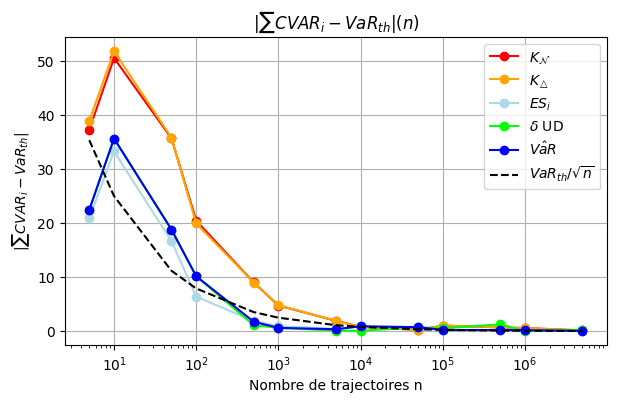

In [250]:
VaR_theoretical = -79.13003132016233
error_quad_diff_VaR = np.sqrt((np.array(Var_sim_list) - VaR_theoretical) ** 2)
plt.figure(figsize=(7, 4))
plt.plot(nb_trajectoire[1:], sqrt_quad_diff_VaR_gaussian_sim[1:], label=r"$K_{\mathcal{N}}$", marker='o', color='red')
plt.plot(nb_trajectoire[1:], sqrt_quad_diff_VaR_triangle_sim[1:], label=r"$K_{\triangle}$", marker='o', color='orange')
plt.plot(nb_trajectoire[1:], sqrt_quad_diff_VaR_esi_sim[1:], label=r'$ES_i$', marker='o', color='#ADD8E6')
plt.plot(nb_trajectoire[1:], sqrt_quad_diff_VaR_shock_ud_sim[1:], label=r'$\delta$ UD', marker='o', color='#00FF00')  # Vert flashy#Var_sim_list
plt.plot(nb_trajectoire[1:], error_quad_diff_VaR[1:], label=r"$V\hat{a}R$", marker='o', color='blue')#VaR (Theoretical): -55.94920711134692
#plt.ayvline(x=-55.94920711134692, color='r', linestyle='--', label='VaR théorique')
C=  79.13003132016233
plt.plot(nb_trajectoire[1:], C / np.sqrt(nb_trajectoire[1:]), label=r"$VaR_{th}/\sqrt{n}$", linestyle='--', color='black')
plt.xscale('log')
plt.xlabel('Nombre de trajectoires n')
plt.ylabel(r"|${\sum CVAR_i - VaR_{th}}$|")
plt.title(r"$|\sum CVAR_i - VaR_{th}|(n)$")
plt.legend()
plt.grid(True)
plt.show()

In [144]:
alphas = np.arange(0.9, 1.0, 0.001)

# Listes pour stocker les résultats
cv_CVARi_0_gaussian = []
cv_CVARi_0_triangle = []
cv_CVARi_0_esi = []
cv_CVARi_0_shock_ud = []
sqrt_quad_diff_VaR_gaussian = []
sqrt_quad_diff_VaR_triangle = []
sqrt_quad_diff_VaR_esi = []
sqrt_quad_diff_VaR_shock_ud = []

cv_CVARi_0_rebased_gaussian = []
cv_CVARi_0_rebased_triangle = []
cv_CVARi_0_rebased_esi = []
cv_CVARi_0_rebased_shock_ud = []
sqrt_quad_diff_VaR_rebased_gaussian = []
sqrt_quad_diff_VaR_rebased_triangle = []
sqrt_quad_diff_VaR_rebased_esi = []
sqrt_quad_diff_VaR_rebased_shock_ud = []

Var_list = []
# Simulation pour chaque alpha
for alpha in alphas:
    results = simulation(5,alpha,5,5000,rho)
    Var_list.append(np.mean(results['VaR_list']))
    cv_CVARi_0_gaussian.append(results['gaussian_stats']['cv_CVARi_0'])
    cv_CVARi_0_triangle.append(results['triangle_stats']['cv_CVARi_0'])
    cv_CVARi_0_esi.append(results['esi_stats']['cv_CVARi_0'])
    cv_CVARi_0_shock_ud.append(results['shock_ud_stats']['cv_CVARi_0'])
    sqrt_quad_diff_VaR_gaussian.append(results['gaussian_stats']['quad_diff_VaR'])
    sqrt_quad_diff_VaR_triangle.append(results['triangle_stats']['quad_diff_VaR'])
    sqrt_quad_diff_VaR_esi.append(results['esi_stats']['quad_diff_VaR'])
    sqrt_quad_diff_VaR_shock_ud.append(results['shock_ud_stats']['quad_diff_VaR'])
    # Ajouter les statistiques recalées
    cv_CVARi_0_rebased_gaussian.append(results['rebased gaussian']['cv_CVARi_0'])
    cv_CVARi_0_rebased_triangle.append(results['rebased triangle']['cv_CVARi_0'])
    cv_CVARi_0_rebased_esi.append(results['esi_stats']['cv_CVARi_0'])
    cv_CVARi_0_rebased_shock_ud.append(results['rebased shock ud']['cv_CVARi_0'])
    
    sqrt_quad_diff_VaR_rebased_gaussian.append(results['rebased gaussian']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_rebased_triangle.append(results['rebased triangle']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_rebased_esi.append(results['esi_stats']['quad_diff_VaR_th'])
    sqrt_quad_diff_VaR_rebased_shock_ud.append(results['rebased shock ud']['quad_diff_VaR_th'])

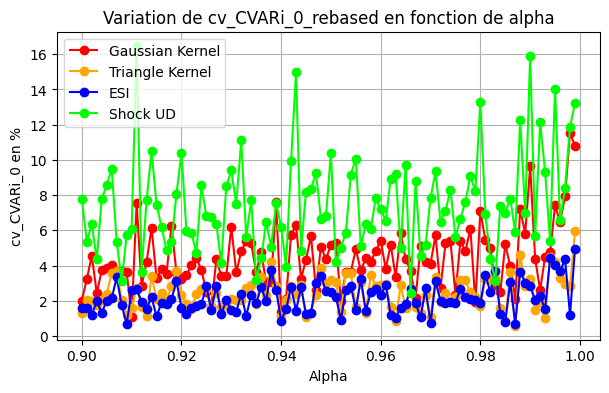

In [145]:
# Tracer les résultats
plt.figure(figsize=(7, 4))
plt.plot(alphas, cv_CVARi_0_rebased_gaussian, label='Gaussian Kernel', marker='o', color='red')
plt.plot(alphas, cv_CVARi_0_rebased_triangle, label='Triangle Kernel', marker='o', color='orange')
plt.plot(alphas, cv_CVARi_0_rebased_esi, label='ESI', marker='o', color='blue')
plt.plot(alphas, cv_CVARi_0_rebased_shock_ud, label='Shock UD', marker='o', color='#00FF00')

plt.xlabel('Alpha')
plt.ylabel('cv_CVARi_0 en %')
plt.title('Variation de cv_CVARi_0_rebased en fonction de alpha')
plt.legend()
plt.grid(True)
plt.show()

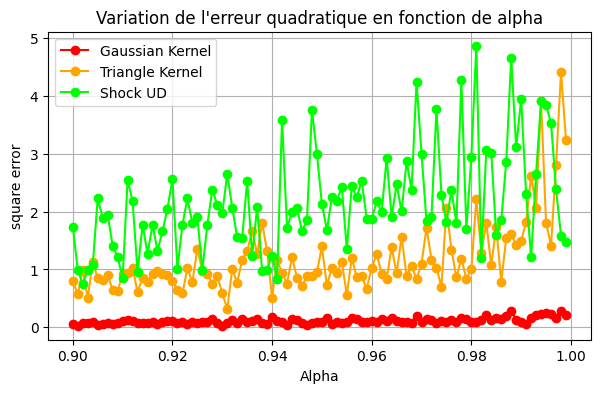

In [149]:
# Tracer les résultats
VaR_theoretical = -79.13003132016233
error_quad_diff_VaR = np.sqrt((np.array(Var_list) - VaR_theoretical) ** 2)
plt.figure(figsize=(7, 4))
plt.plot(alphas, sqrt_quad_diff_VaR_gaussian, label='Gaussian Kernel', marker='o', color='red')
plt.plot(alphas, sqrt_quad_diff_VaR_rebased_triangle, label='Triangle Kernel', marker='o', color='orange')
#plt.plot(alphas, sqrt_quad_diff_VaR_esi, label='ESI', marker='o', color='blue')
plt.plot(alphas, sqrt_quad_diff_VaR_shock_ud, label='Shock UD', marker='o', color='#00FF00')
#plt.plot(alphas, error_quad_diff_VaR, label='VaR empirique', marker='o', color='blue')##ADD8E6

plt.xlabel('Alpha')
plt.ylabel('square error')
plt.title("Variation de l'erreur quadratique en fonction de alpha")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
CVARi_triangle_first_list_rebased = list(np.array(CVARi_triangle_first_list) * np.array(VaR_empirical_list)/np.array(Sum_CVARi_triangle_list))
CVARi_shock_ud_first_list_rebased = list(np.array(CVARi_shock_ud_first_list) * np.array(VaR_empirical_list)/np.array(Sum_CVARi_shock_ud_list))

# AFFICHAGE DES RESULTATS

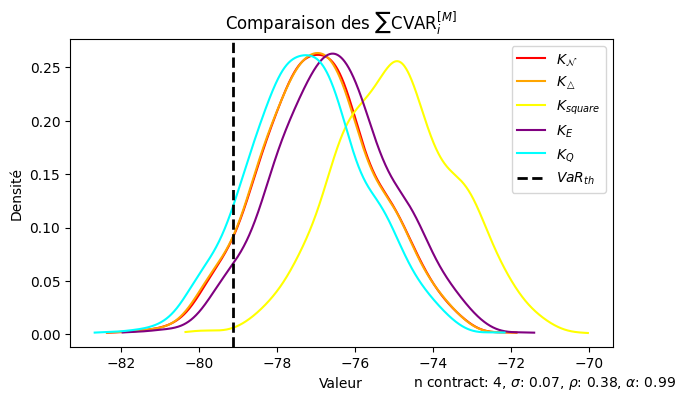

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Création des courbes lissées des histogrammes
def plot_smoothed_histogram(data, label, color):
    kde = gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 1000)
    if data == Sum_CVARi_kernel_list:
        plt.plot(x_range, kde(x_range), label=label, color=color)
    else:
        plt.plot(x_range, kde(x_range), label=label, color=color)

plt.figure(figsize=(7, 4))

# Affichage des courbes lissées des histogrammes
#plot_smoothed_histogram(VaR_empirical_list, r'$V\hat{a}R_\alpha$', "blue")
#plot_smoothed_histogram(Sum_CVARi_shock_ud_list, r"up down $\delta$ = 10%", "green")#90EE90#006400
#plot_smoothed_histogram(Sum_CVARi_shock_list, r"right $\delta$ = 10%", "#90EE90")#90EE90
#plot_smoothed_histogram(Sum_CVARi_shock_left_list, r"left $\delta$ = 10%", "#006400")
#plot_smoothed_histogram(Sum_CVARi_shock_4p_list, r"4p $\delta$ = 12%", "#FFD700")#Sum_CVARi_shock_4p_list
#plot_smoothed_histogram(Sum_CVARi_shock_6p_list, r"6p $\delta$ = 59%", "#FFA500")
plot_smoothed_histogram(Sum_CVARi_kernel_list, r'$K_{\mathcal{N}}$', "red")
plot_smoothed_histogram(Sum_CVARi_triangle_list, r'$K_{\triangle}$', "orange")  # CVARi_triangle_first_list_rebased
plot_smoothed_histogram(Sum_CVARi_rectangle_list, r'$K_{square}$', "yellow")
plot_smoothed_histogram(Sum_CVARi_epanechnikov_list, r'$K_E$', "purple")
plot_smoothed_histogram(Sum_CVARi_quartic_list, r'$K_Q$', "cyan")
#rebased
#plot_smoothed_histogram(gaussian_sum_rebased, "gaussian rebased sum CVARi","red")
#plot_smoothed_histogram(triangle_sum_rebased, "${\triangle}$[R]","lightsalmon")
#plot_smoothed_histogram(shock_ud_sum_rebased, "shock ud rebased sum CVARi","#00FF00")

# Ajout d'un trait vertical pour VaR (Theoretical)
plt.axvline(x=VaR_theoretical, color='black', linestyle='--', linewidth=2, label=r"$VaR_{th}$")#f"$VaR_Th$: {round(VaR_theoretical,2)}")
#VaR_theoretical = calculate_theoretical_VaR(nominales, cov_matrix, confidence_level)
# Configuration du graphique
plt.figtext(0.99, 0.01, f"n contract: {n_components}, $\sigma$: {round(volatility,2)}, $\\rho$: {rho}, $\\alpha$: {confidence_level}", horizontalalignment='right')
plt.title(r"Comparaison des $\sum \text{CVAR}_i^{[M]}$")
plt.xlabel("Valeur")
plt.ylabel("Densité")
plt.legend()
plt.show()

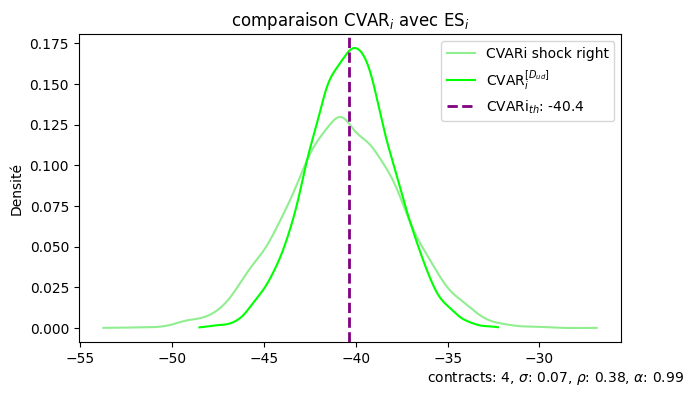

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Création des courbes lissées des histogrammes
def plot_smoothed_histogram(data, label, color, linestyle='-'):
    kde = gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 1000)
    plt.plot(x_range, kde(x_range), label=label, color=color, linestyle=linestyle)

plt.figure(figsize=(7, 4))

# Affichage des courbes lissées des histogrammes
#plot_smoothed_histogram(ESi_first_list, "ESi", "blue")
#plot_smoothed_histogram(CVARi_extractio_first_list_prime, "CVARi extration scénario", "purple")#[sublist[0] for sublist in CVARi_extractio_first_list]
#plot_smoothed_histogram(CVARi_shock_first_list, "CVARi shock right", "#90EE90")#CVARi_shock_ud_first_list
#plot_smoothed_histogram(CVARi_shock_left_first_list, "CVARi shock left", "#006400")#CVARi_shock_4p_first_list
#plot_smoothed_histogram(CVARi_shock_ud_first_list, r"CVAR$_i^{[D_{ud}]}$", "#00FF00")
plot_smoothed_histogram(CVARi_kernel_first_list, r"CVAR$_i^{[K_{\mathcal{N}}]}$", "red")
#plot_smoothed_histogram(CVARi_rectangle_first_list, "CVARi kernel rectangle", "yellow")
#plot_smoothed_histogram(CVARi_triangle_first_list, r"CVAR$_i^{[K_{\triangle}]}$", "orange")#CVARi_triangle_first_list_rebased
#plot_smoothed_histogram(CVARi_triangle_first_list_rebased, "CVARi kernel triangle rebasé", "lightsalmon")#VaR_ind_first_list_rebased
#plot_smoothed_histogram(VaR_ind_first_list_rebased, "VaRi rebasé", "pink")
# Ajout de traits verticaux pour les valeurs théoriques
#REBASED
#gaussian_list_rebased=[]
#triangle_list_rebased=[]
#shock_ud_list_rebased=[]
#plot_smoothed_histogram(gaussian_list_rebased, r"CVAR$_i^{[K_{\mathcal{N}},R]}$", "#FF69B4")
#plot_smoothed_histogram(triangle_list_rebased, r"CVAR$_i^{[K_{\triangle},R]}$", "lightsalmon")
#plot_smoothed_histogram(shock_ud_list_rebased, r"CVAR$_i^{[D_{ud},R]}$", "#228B22")

#plt.axvline(x=VaR_theoretical, color='black', linestyle='--', linewidth=2, label=f"VaR Theoretical: {VaR_theoretical}")
plt.axvline(x=CVARi_theoretical[0], color='purple', linestyle='--', linewidth=2, label=r"CVARi$_{th}$" + f": {round(CVARi_theoretical[0],1)}")

plt.figtext(0.99, 0.01, f"contracts: {n_components}, $\sigma$: {round(volatility,2)}, $\\rho$: {rho}, $\\alpha$: {confidence_level}", 
            horizontalalignment='right')

# Configuration du graphique
#plt.title(r"comparaison CVAR$_i^{[M]}$ avec CVAR$_i^{[M,R]}$")
plt.title(r"comparaison CVAR$_i$ avec ES$_i$")
plt.ylabel("Densité")
plt.legend()
plt.show()


In [266]:
import pandas as pd
from scipy.stats import kurtosis, skew
def calculate_statistics(data_list):
    """ Calculate statistics for a given list. """
    mu = round(np.mean(data_list), 1)
    sigma = round(np.std(data_list), 1)
    min_val = round(np.min(data_list), 1)
    max_val = round(np.max(data_list), 1)
    kurt = round(kurtosis(data_list), 3)
    skewness = round(skew(data_list), 3)
    return mu, sigma, min_val, max_val, kurt, skewness

# Calcul des statistiques pour chaque liste
data = {
    "Méthode": [
        r"$ES_i$",
        r"$CVaR_i^{[K_{\mathcal{N}},R]}$",
        r"$CVaR_i^{[\delta, ud, R]}$",
        r"$CVaR_i^{[K_{\triangle},R]}$",
        r"$CVaR_i^{[K_{gaussien}]}$",
        r"$CVaR_i^{[K_{triangle}]}$",
        r"$CVaR_i^{[\delta, ud]}$"
    ],
    "$\mu$": [],
    "$\sigma$": [],
    "Min": [],
    "Max": [],
    r"$\kappa$": [],
    r"$\gamma$": []
}


lists = [
    ESi_first_list,
    gaussian_list_rebased,
    shock_ud_list_rebased,
    triangle_list_rebased,
    CVARi_kernel_first_list,
    CVARi_triangle_first_list,
    CVARi_shock_ud_first_list
]

for data_list in lists:
    mu, sigma, min_val, max_val, kurt, skewness = calculate_statistics(data_list)
    data["$\mu$"].append(mu)
    data["$\sigma$"].append(sigma)
    data["Min"].append(min_val)
    data["Max"].append(max_val)
    data["$\kappa$"].append(kurt)
    data["$\gamma$"].append(skewness)

# Création du DataFrame
df = pd.DataFrame(data)

def highlight_best(s):
    is_best_mean = np.abs(s["$\mu$"] - CVARi_theoretical) == np.min(np.abs(df["$\mu$"] - CVARi_theoretical))
    is_best_sigma = s["$\sigma$"] == np.min(df["$\sigma$"])
    is_best_min = s["Min"] == np.max(df["Min"])
    is_best_max = s["Max"] == np.min(df["Max"])
    is_best_kurtosis = np.abs(s["$\kappa$"] - 3) == np.min(np.abs(df["$\kappa$"] - 3))
    is_best_skew = np.abs(s["$\gamma$"] - 0) == np.min(np.abs(df["$\gamma$"] - 0))

    return [
        'background-color: green' if is_best_mean or is_best_sigma or is_best_min or is_best_max or is_best_kurtosis or is_best_skew else ''
        for _ in range(len(s))
    ]

# Application du style
#styled_df = df.style.apply(highlight_best, axis=1)
#"\\DSV0000002.ap.cdc.fr\DFS_USERS$\mjactat\Profile\Desktop\statistics_table.xlsx"
df.to_excel("C:\Local\statistics_table.xlsx", index=False)
df

,Méthode,$\mu$,$\sigma$,Min,Max,$\kappa$,$\gamma$
0,$ES_i$,-40.3,0.9,-43.9,-36.9,-0.079,-0.068
1,"$CVaR_i^{[K_{\mathcal{N}},R]}$",-40.3,1.0,-44.4,-36.5,-0.061,-0.080
2,"$CVaR_i^{[\delta, ud, R]}$",-40.3,2.4,-50.9,-29.9,0.061,-0.054
3,"$CVaR_i^{[K_{\triangle},R]}$",-40.3,1.0,-44.1,-36.5,-0.056,-0.081
4,$CVaR_i^{[K_{gaussien}]}$,-39.2,1.1,-43.3,-35.5,-0.058,-0.099
5,$CVaR_i^{[K_{triangle}]}$,-39.2,1.1,-43.2,-35.5,-0.051,-0.102
6,"$CVaR_i^{[\delta, ud]}$",-40.3,2.3,-50.0,-31.9,-0.036,-0.016


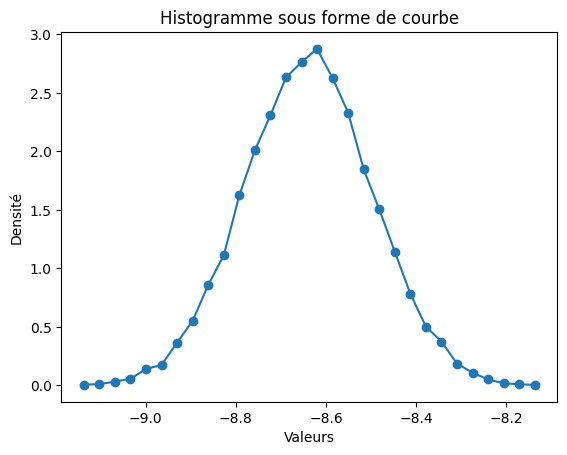

In [199]:
import numpy as np
import matplotlib.pyplot as plt

def histogram_curve(data, bins=10, density=True):
    counts, bin_edges = np.histogram(data, bins=bins, density=density)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, '-o')
    plt.xlabel('Valeurs')
    plt.ylabel('Densité' if density else 'Fréquence')
    plt.title('Histogramme sous forme de courbe')
    plt.show()
data = VaR_ind_first_list_rebased
histogram_curve(data, bins=30)


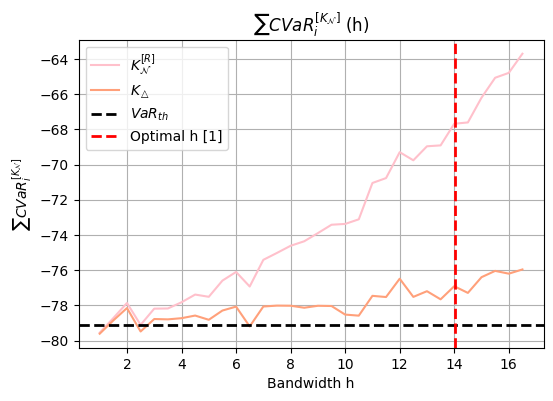

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from concurrent.futures import ProcessPoolExecutor, as_completed

def kernel_function_h(x, bandwidth, kernel_type="gaussian"):
    x_scaled = x/bandwidth
    if kernel_type == "gaussian":
        return  norm.pdf(x_scaled)#, scale = (bandwidth/math.sqrt(6)))
    elif kernel_type == "triangle":
        return np.where(np.abs(x_scaled) <= 1, (1 - np.abs(x_scaled)) / bandwidth, 0)
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")

def calculate_CVARi_h(PnL_matrix,confidence_level, kernel_type,bandwidth):
    n_scenarios, n_components = PnL_matrix.shape
    PnL_total = np.sum(PnL_matrix, axis=1)
    VaR = calculate_VaR(PnL_total, confidence_level)
    distances = (PnL_total - VaR)
    #if kernel_type == "triangle":
        #bandwidth = 2.6*portfolio_volatility/(num_traj)**(1/5)
        #distances = (PnL_total - VaR) / bandwidth
    weights = kernel_function_h(distances,bandwidth,kernel_type)
    weights /= np.sum(weights)
    #print(len([weight for weight in weights if not weight == 0])) for 10k traj : 3033 gaussian, 890 for triangle and square
    CVARi = np.zeros(n_components)
    for i in range(n_components):
        CVARi[i] = np.sum(weights * PnL_matrix[:, i])
    return CVARi, VaR
# Parameter of the model
num_traj = 10000  # Nombre de trajectoire
volatility = 0.1 * math.sqrt(0.5)  # Exemple de volatilité (10% annuel à 6 mois)
rho = 0.38  # Coefficient de corrélation unique
confidence_level = 0.99
nominales = np.array([100, 100, 50, 50])  # Nominales des actifs
volatilities = np.array([0.2, 0.1, 0.2, 0.1])
n_components = len(nominales)

# Matrice de corrélation
corr_matrix = np.full((n_components, n_components), rho)
np.fill_diagonal(corr_matrix, 1)

weights = np.ones(n_components) / n_components  # Vecteur de poids des actifs
mean_returns = np.zeros(n_components)  # Rendements moyens
cov_matrix = np.diag(volatilities) @ corr_matrix @ np.diag(volatilities)

# Volatilité sur tout le portefeuille
portfolio_volatility = np.sqrt(np.dot(nominales, np.dot(cov_matrix, nominales)))

# Liste des largeurs de bande à tester
bandwidths = np.arange(1, 17, 0.5) 
Sum_CVARi_mean_gaussian = []
Sum_CVARi_mean_triangle = []
# Calculer CVaR_i pour différentes largeurs de bande
for bandwidth in bandwidths:
    Sum_CVARi_samples_gaussian = []
    Sum_CVARi_samples_triangle = []
    
    for _ in range(10):  # 1000 tests for each bandwidth
        returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_traj)
        PnL_matrix = returns @ np.diag(nominales)
        
        # Gaussian Kernel
        CVARi_gaussian, VaR_gaussian = calculate_CVARi_h(PnL_matrix, confidence_level, "gaussian", bandwidth)
        CVARi_rebased_gaussian = CVARi_gaussian# * VaR_gaussian / np.sum(CVARi_gaussian)
        Sum_CVARi_samples_gaussian.append(sum(CVARi_rebased_gaussian))
        
        # Triangle Kernel
        CVARi_triangle, VaR_triangle = calculate_CVARi_h(PnL_matrix, confidence_level, "triangle", bandwidth)
        CVARi_rebased_triangle = CVARi_triangle# * VaR_triangle / np.sum(CVARi_triangle)
        Sum_CVARi_samples_triangle.append(sum(CVARi_rebased_triangle))
    
    Sum_CVARi_mean_gaussian.append(np.mean(Sum_CVARi_samples_gaussian))
    Sum_CVARi_mean_triangle.append(np.mean(Sum_CVARi_samples_triangle))

VaR_theoretical = calculate_theoretical_VaR(nominales, cov_matrix, confidence_level)
CVARi_theoretical = calculate_theoretical_CVARi(nominales, cov_matrix, confidence_level)
# Tracer les résultats
plt.figure(figsize=(6, 4))
plt.plot(bandwidths, Sum_CVARi_mean_gaussian, linestyle='-', color='pink', label=r"$K_{\mathcal{N}}^{[R]}$")
plt.plot(bandwidths, Sum_CVARi_mean_triangle, linestyle='-', color='lightsalmon', label=r"$K_{\triangle}$")#\mathcal{N}}$")
#plt.axhline(y=VaR_theoretical, color='black', linestyle='--', linewidth=2, label=r"$VaR_{th}$")
plt.axhline(y=VaR_theoretical, color='black', linestyle='--', linewidth=2, label=r"$VaR_{th}$")
plt.axvline(x=2.6*portfolio_volatility/(num_traj)**(1/5), color='red', linestyle='--', linewidth=2, label='Optimal h [1]')
plt.xlabel('Bandwidth h')
plt.ylabel('$\sum CVaR_i^{[K_\mathcal{N}]}$')
plt.title('$\sum CVaR_i^{[K_{\mathcal{N}}]}$ (h)')
plt.legend()
plt.grid(True)
plt.show()


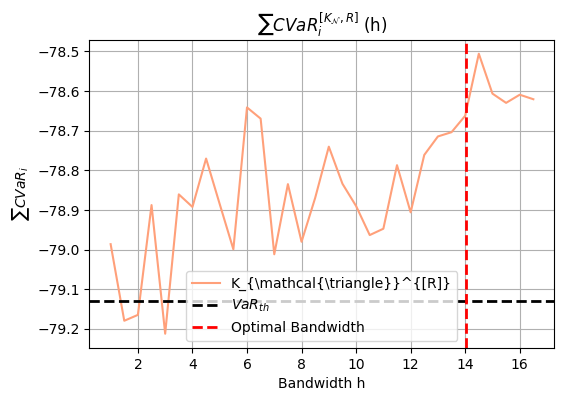

In [217]:
plt.figure(figsize=(6, 4))
#plt.plot(bandwidths, Sum_CVARi_mean_gaussian, linestyle='-', color='pink', label=r"K_{\mathcal{N}}^{[no R]}")
plt.plot(bandwidths, Sum_CVARi_mean_triangle, linestyle='-', color='lightsalmon', label=r"$K_{\mathcal{\triangle}}^{[R]}$")
#plt.axhline(y=VaR_theoretical, color='black', linestyle='--', linewidth=2, label=r"$VaR_{th}$")
plt.axhline(y=VaR_theoretical, color='black', linestyle='--', linewidth=2, label=r"$VaR_{th}$")
plt.axvline(x=2.6*portfolio_volatility/(num_traj)**(1/5), color='red', linestyle='--', linewidth=2, label='Optimal Bandwidth')
plt.xlabel('Bandwidth h')
plt.ylabel('$\sum CVaR_i$')
plt.title('$\sum CVaR_i^{[K_{\mathcal{N}},R]}$ (h)')
plt.legend()
plt.grid(True)
plt.show()